In [1]:
from sys import path
path.append('../src/')

import os
import numpy as np
import matplotlib.pyplot as plt
import mlflow
import mlflow.keras
import pickle as pkl
import random as rn
import tensorflow as tf

from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Dense, GlobalAvgPool2D
from keras.models import Model, load_model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.utils import compute_class_weight

from global_config import FILE_DUMP_IMAGES, FILE_DUMP_MRKS, FOLDER_MODELS 
from global_config import RANDOM_SEED, IMAGE_SIZE, USER_IDS
from utils import load, plot
from custom_losses import precision, recall, f1, specificity 
from custom_losses import negative_predictive_value as npv 
from custom_losses import matthews_correlation_coefficient as mcc

%matplotlib inline

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\tensorflow\python\util\nest.py:823: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  _pywrap_tensorflow.RegisterType("Mapping", _collections.Mapping)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\tensorflow\python\training\checkpointable\data_structures.py:312: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  class _ListWrapper(List, collections.MutableSequence,
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\tensorflow\python\training\checkpointable\util.py:448: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  class _ObjectIdentitySet(collections.MutableSet):
Using Te

In [2]:
print(FILE_DUMP_IMAGES)
print(FILE_DUMP_MRKS)
print(FOLDER_MODELS)
print(IMAGE_SIZE)
print(RANDOM_SEED)
print(USER_IDS)

../data/pybossa/pybossa_images.pkl
../data/pybossa/pybossa_mrks.pkl
../models/autoencoders_requirements/
(224, 224)
42
1_3_6


In [3]:
TEST_SIZE = 0.2

MLFLOW_EXPERIMENT_NAME = 'Autoencoder Requirements'

FILE_BASE_MODEL = '../models/autoencoders_unsupervised/model_2020_03_15-10_43_27.h5'
FILE_MERGED_MODEL = f'{FOLDER_MODELS}merged_model_{USER_IDS}.h5'

In [4]:
def timestamp_model_name(prefix='model_', suffix='', format='%Y_%m_%d-%H_%M_%S', ext='.h5'):
    from datetime import datetime
    timestamp = datetime.now().strftime(format)
    return f'{prefix}{timestamp}{suffix}{ext}'

def set_random_seeds():
    os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)
    rn.seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)
    tf.set_random_seed(RANDOM_SEED)
    
def plot_metrics(y_true, y_pred, hist):
    conf_matrix = confusion_matrix(y_true, y_pred) 
    tn, fp, fn, tp = conf_matrix.ravel()
    
    accuracy_sk = accuracy_score(y_true, y_pred)
    precision_sk = precision_score(y_true, y_pred)
    recall_sk = recall_score(y_true, y_pred)
    f_measure = f1_score(y_true, y_pred)
    specificity_sk = tn / (tn + fp + 1e-7)
    npv_sk = tn / (tn + fn + 1e-7)
    
    num = tp * tn - fp * fn
    den = (tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)
    mcc_sk = num / np.sqrt(den + 1e-7)
    
    print()
    print('   Final Accuracy: {:=6.2f}%'.format(accuracy_sk * 100))
    print('  Final Precision: {:=6.2f}%'.format(precision_sk * 100))
    print('     Final Recall: {:=6.2f}%'.format(recall_sk * 100))
    print('  Final F-measure: {:=6.2f}%'.format(f_measure * 100))
    print('Final Specificity: {:=6.2f}%'.format(specificity_sk * 100))
    print('        Final NPV: {:=6.2f}%'.format(npv_sk * 100))
    print('        Final MCC: {:=6.2f}%'.format(mcc_sk * 100))    

    print(confusion_matrix(y_true, y_pred))
    print(classification_report(y_true, y_pred))
    plot.keras_hist(hist.history)

In [5]:
def build_model(base_model, name):
    set_random_seeds()

    outputs = Dense(units=64, activation='relu', name=f'{name}_1')(base_model.output)
    outputs = Dense(units=32, activation='relu', name=f'{name}_2')(outputs)
    outputs = Dense(units=1, activation='sigmoid', name=f'{name}')(outputs)
    model = Model(inputs=base_model.inputs, outputs=outputs)

    for layer in model.layers:
        layer.trainable = (name in layer.name)

    model.compile(
        optimizer='adam', 
        loss='binary_crossentropy', 
        metrics=['accuracy', precision, recall, f1, specificity, npv, mcc]
    )
    return model


def train_model(model, x_train, y_train, x_val, y_val, name):
    FILE_MODEL = FOLDER_MODELS + timestamp_model_name(prefix=f'{name}_')
    metric_to_monitor = 'val_matthews_correlation_coefficient'
    
    list_callbacks = [
        EarlyStopping(monitor=metric_to_monitor, mode='max', patience=30, verbose=1, restore_best_weights=True),
        ModelCheckpoint(FILE_MODEL, monitor=metric_to_monitor, mode='max', verbose=1, save_best_only=True)
    ]
    
    classes = np.unique(y_train)
    weights = compute_class_weight('balanced', classes, y_train)
    class_weights = dict(zip(classes, weights))
    u_train, c_train = np.unique(y_train, return_counts=True)
    u_val, c_val = np.unique(y_val, return_counts=True)
    
    mlflow.set_experiment(MLFLOW_EXPERIMENT_NAME)
    mlflow.log_param("test_size", TEST_SIZE)
    mlflow.log_param("seed", RANDOM_SEED)
    mlflow.log_param("class_train", dict(zip(u_train, c_train)))
    mlflow.log_param("class_val", dict(zip(u_val, c_val)))
    mlflow.log_param("class_train_prop", dict(zip(u_train, c_train / c_train.sum())))
    mlflow.log_param("class_val_prop", dict(zip(u_val, c_val / c_val.sum())))
    mlflow.set_tag("requirement", name)
    mlflow.set_tag("user_ids", USER_IDS)
    mlflow.keras.autolog()

    hist = model.fit(
        x_train / 255, 
        y_train, 
        batch_size=32, 
        epochs=100, 
        validation_data=(x_val / 255, y_val),
        class_weight=class_weights,
        callbacks=list_callbacks
    )
    mlflow.end_run()
    
    return hist, FILE_MODEL


def train_requirement_branch(base_model, x, y, name):
    classes, counts = np.unique(y, return_counts=True) 
    if len(classes) == 1:
        print(f"the requirement {name} has only one label.")
        return None
    
    if min(counts) == 1:
        print(f"the requirement {name} has only one sample for one of the classes.")
        return None

    x_train, x_val, y_train, y_val = train_test_split(
        x, y, 
        test_size=TEST_SIZE, 
        stratify=y, 
        random_state=RANDOM_SEED
    )

    model = build_model(base_model, name)
    hist, file_model = train_model(model, x_train, y_train, x_val, y_val, name)
    
    y_pred = model.predict(x_val / 255)
    y_pred = np.where(y_pred > 0.5, 1, 0)
    plot_metrics(y_val, y_pred, hist)

    return file_model

# Load Autoencoder 

In [6]:
model = load_model(FILE_BASE_MODEL)

embeddings = GlobalAvgPool2D(name='embeddings')(model.get_layer(name='encoded').output)

encoder = Model(inputs=model.inputs, outputs=embeddings)
encoder.summary()

Instructions for updating:
Colocations handled automatically by placer.


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


Instructions for updating:
Use tf.cast instead.
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 224, 224, 3)       0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 224, 224, 16)      448       
_________________________________________________________________
bn_1 (BatchNormalization)    (None, 224, 224, 16)      64        
_________________________________________________________________
relu_1 (Activation)          (None, 224, 224, 16)      0         
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 112, 112, 16)      0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 112, 112, 32)      4640      
_________________________________________________________________
bn_2 (Batch

# Requirements Training

In [7]:
x, _ = pkl.load(open(FILE_DUMP_IMAGES, 'rb'))
mrks, _ = pkl.load(open(FILE_DUMP_MRKS, 'rb'))

print(x.shape, x.dtype)
print(mrks.shape, mrks.dtype)

list_model_files = []

(5763, 224, 224, 3) float32
(5763,) object


#### 2. Blurred

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 12s 3ms/step - loss: 0.5260 - accuracy: 0.6564 - precision: 0.9392 - recall: 0.6316 - f1: 0.7454 - specificity: 0.8188 - negative_predictive_value: 0.2828 - matthews_correlation_coefficient: 0.3182 - val_loss: 0.4973 - val_accuracy: 0.7303 - val_precision: 0.9557 - val_recall: 0.7239 - val_f1: 0.8204 - val_specificity: 0.7701 - val_negative_predictive_value: 0.3072 - val_matthews_correlation_coefficient: 0.3541

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.35412, saving model to ../models/autoencoders_requirements/blurred_2020_03_24-12_31_01.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4771 - accuracy: 0.6850 - precision: 0.9606 - recall: 0.6668 - f1: 0.7763 - specificity: 0.8172 - negative_predictive_value: 0.3090 - matthews_correlation_coefficient: 0.3543 - val_loss: 0.4085 - val_accuracy: 0.7979 - val_precision: 0.

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4262 - accuracy: 0.7425 - precision: 0.9680 - recall: 0.7246 - f1: 0.8248 - specificity: 0.8405 - negative_predictive_value: 0.3452 - matthews_correlation_coefficient: 0.4158 - val_loss: 0.4053 - val_accuracy: 0.7858 - val_precision: 0.9488 - val_recall: 0.7972 - val_f1: 0.8646 - val_specificity: 0.7358 - val_negative_predictive_value: 0.3607 - val_matthews_correlation_coefficient: 0.3989

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.41755
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4210 - accuracy: 0.7488 - precision: 0.9655 - recall: 0.7343 - f1: 0.8299 - specificity: 0.8344 - negative_predictive_value: 0.3466 - matthews_correlation_coefficient: 0.4149 - val_loss: 0.4432 - val_accuracy: 0.7658 - val_precision: 0.9618 - val_recall: 0.7608 - val_f1: 0.8469 - val_specificity: 0.8051 - val_negative_predictive_value: 0.3481 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4229 - accuracy: 0.7375 - precision: 0.9648 - recall: 0.7098 - f1: 0.8120 - specificity: 0.8631 - negative_predictive_value: 0.3484 - matthews_correlation_coefficient: 0.4252 - val_loss: 0.4746 - val_accuracy: 0.7771 - val_precision: 0.9579 - val_recall: 0.7778 - val_f1: 0.8561 - val_specificity: 0.7824 - val_negative_predictive_value: 0.3584 - val_matthews_correlation_coefficient: 0.4141

Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.44423
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4682 - accuracy: 0.7037 - precision: 0.9693 - recall: 0.6804 - f1: 0.7809 - specificity: 0.8554 - negative_predictive_value: 0.3357 - matthews_correlation_coefficient: 0.3963 - val_loss: 0.4254 - val_accuracy: 0.7849 - val_precision: 0.9607 - val_recall: 0.7850 - val_f1: 0.8618 - val_specificity: 0.7916 - val_negative_predictive_value: 0.3716 - val_matthews_correlation_coefficie


Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.47088
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3868 - accuracy: 0.7803 - precision: 0.9751 - recall: 0.7613 - f1: 0.8517 - specificity: 0.8436 - negative_predictive_value: 0.3833 - matthews_correlation_coefficient: 0.4626 - val_loss: 0.3829 - val_accuracy: 0.7997 - val_precision: 0.9576 - val_recall: 0.8056 - val_f1: 0.8733 - val_specificity: 0.7696 - val_negative_predictive_value: 0.3837 - val_matthews_correlation_coefficient: 0.4366

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.47088
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3871 - accuracy: 0.7831 - precision: 0.9748 - recall: 0.7673 - f1: 0.8538 - specificity: 0.8547 - negative_predictive_value: 0.3912 - matthews_correlation_coefficient: 0.4698 - val_loss: 0.3509 - val_accuracy: 0.8196 - val_precision: 0.9479 - val_recall: 0.8397 - val_f1: 0.8889 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3857 - accuracy: 0.7779 - precision: 0.9723 - recall: 0.7642 - f1: 0.8514 - specificity: 0.8676 - negative_predictive_value: 0.3877 - matthews_correlation_coefficient: 0.4692 - val_loss: 0.3272 - val_accuracy: 0.8534 - val_precision: 0.9555 - val_recall: 0.8724 - val_f1: 0.9107 - val_specificity: 0.7386 - val_negative_predictive_value: 0.4899 - val_matthews_correlation_coefficient: 0.5155

Epoch 00058: val_matthews_correlation_coefficient improved from 0.48804 to 0.51547, saving model to ../models/autoencoders_requirements/blurred_2020_03_24-12_31_01.h5
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3789 - accuracy: 0.7948 - precision: 0.9750 - recall: 0.7823 - f1: 0.8647 - specificity: 0.8717 - negative_predictive_value: 0.4069 - matthews_correlation_coefficient: 0.4908 - val_loss: 0.4156 - val_accuracy: 0.7840 - val_precision: 0.9678 - val_recall: 0.7775 - val_f1: 0.8602 - val_specific

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3707 - accuracy: 0.7996 - precision: 0.9715 - recall: 0.7885 - f1: 0.8667 - specificity: 0.8867 - negative_predictive_value: 0.4198 - matthews_correlation_coefficient: 0.5067 - val_loss: 0.4552 - val_accuracy: 0.7615 - val_precision: 0.9749 - val_recall: 0.7463 - val_f1: 0.8427 - val_specificity: 0.8707 - val_negative_predictive_value: 0.3556 - val_matthews_correlation_coefficient: 0.4432

Epoch 00072: val_matthews_correlation_coefficient did not improve from 0.51547
Epoch 73/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4443 - accuracy: 0.7529 - precision: 0.9682 - recall: 0.7380 - f1: 0.8271 - specificity: 0.8586 - negative_predictive_value: 0.3732 - matthews_correlation_coefficient: 0.4402 - val_loss: 0.4194 - val_accuracy: 0.7832 - val_precision: 0.9724 - val_recall: 0.7732 - val_f1: 0.8591 - val_specificity: 0.8453 - val_negative_predictive_value: 0.3732 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3575 - accuracy: 0.8091 - precision: 0.9762 - recall: 0.7985 - f1: 0.8758 - specificity: 0.8710 - negative_predictive_value: 0.4264 - matthews_correlation_coefficient: 0.5113 - val_loss: 0.4038 - val_accuracy: 0.7962 - val_precision: 0.9687 - val_recall: 0.7917 - val_f1: 0.8693 - val_specificity: 0.8160 - val_negative_predictive_value: 0.3812 - val_matthews_correlation_coefficient: 0.4545

Epoch 00087: val_matthews_correlation_coefficient did not improve from 0.51547
Epoch 88/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3463 - accuracy: 0.8152 - precision: 0.9783 - recall: 0.8034 - f1: 0.8797 - specificity: 0.8815 - negative_predictive_value: 0.4428 - matthews_correlation_coefficient: 0.5308 - val_loss: 0.3165 - val_accuracy: 0.8517 - val_precision: 0.9356 - val_recall: 0.8912 - val_f1: 0.9119 - val_specificity: 0.6065 - val_negative_predictive_value: 0.4730 - val_matthews_correlation_coefficie

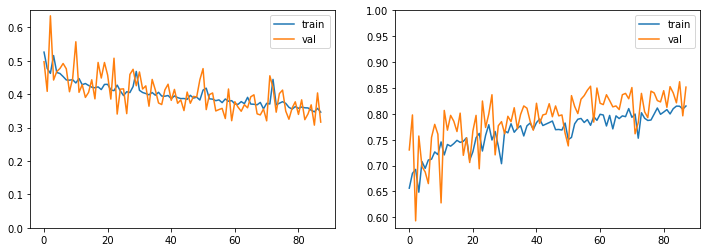

In [8]:
y = np.array([mrk.photo_reqs.blurred.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'blurred')
list_model_files.append(model_file)

#### 3. Looking Away

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6686 - accuracy: 0.6009 - precision: 0.7651 - recall: 0.5961 - f1: 0.6500 - specificity: 0.6096 - negative_predictive_value: 0.4304 - matthews_correlation_coefficient: 0.2059 - val_loss: 0.6831 - val_accuracy: 0.6071 - val_precision: 0.7460 - val_recall: 0.5995 - val_f1: 0.6564 - val_specificity: 0.5788 - val_negative_predictive_value: 0.4120 - val_matthews_correlation_coefficient: 0.1944

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.19435, saving model to ../models/autoencoders_requirements/looking_away_2020_03_24-12_43_57.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6585 - accuracy: 0.6249 - precision: 0.7810 - recall: 0.6312 - f1: 0.6832 - specificity: 0.6217 - negative_predictive_value: 0.4529 - matthews_correlation_coefficient: 0.2418 - val_loss: 0.6648 - val_accuracy: 0.6305 - val_precision

4610/4610 [==============================] - 9s 2ms/step - loss: 0.6242 - accuracy: 0.6497 - precision: 0.8076 - recall: 0.6411 - f1: 0.7022 - specificity: 0.6667 - negative_predictive_value: 0.4741 - matthews_correlation_coefficient: 0.2932 - val_loss: 0.6220 - val_accuracy: 0.6505 - val_precision: 0.7250 - val_recall: 0.7184 - val_f1: 0.7158 - val_specificity: 0.4630 - val_negative_predictive_value: 0.4573 - val_matthews_correlation_coefficient: 0.2068

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.28406
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6228 - accuracy: 0.6531 - precision: 0.8080 - recall: 0.6470 - f1: 0.7071 - specificity: 0.6682 - negative_predictive_value: 0.4829 - matthews_correlation_coefficient: 0.3035 - val_loss: 0.6112 - val_accuracy: 0.6609 - val_precision: 0.7562 - val_recall: 0.6818 - val_f1: 0.7110 - val_specificity: 0.5621 - val_negative_predictive_value: 0.4723 - val_matthews_correlation_coefficie


Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.30252
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5881 - accuracy: 0.6768 - precision: 0.8293 - recall: 0.6551 - f1: 0.7219 - specificity: 0.7247 - negative_predictive_value: 0.5080 - matthews_correlation_coefficient: 0.3585 - val_loss: 0.7527 - val_accuracy: 0.5594 - val_precision: 0.8097 - val_recall: 0.4280 - val_f1: 0.5530 - val_specificity: 0.8083 - val_negative_predictive_value: 0.4198 - val_matthews_correlation_coefficient: 0.2316

Epoch 00030: val_matthews_correlation_coefficient did not improve from 0.30252
Epoch 31/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5851 - accuracy: 0.6826 - precision: 0.8351 - recall: 0.6745 - f1: 0.7355 - specificity: 0.7082 - negative_predictive_value: 0.5103 - matthews_correlation_coefficient: 0.3624 - val_loss: 0.5810 - val_accuracy: 0.6904 - val_precision: 0.7789 - val_recall: 0.6960 - val_f1: 0.7315 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5627 - accuracy: 0.6963 - precision: 0.8362 - recall: 0.6941 - f1: 0.7497 - specificity: 0.7175 - negative_predictive_value: 0.5386 - matthews_correlation_coefficient: 0.3914 - val_loss: 0.6039 - val_accuracy: 0.6288 - val_precision: 0.7988 - val_recall: 0.5522 - val_f1: 0.6474 - val_specificity: 0.7514 - val_negative_predictive_value: 0.4679 - val_matthews_correlation_coefficient: 0.2837

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.34515
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5554 - accuracy: 0.6911 - precision: 0.8329 - recall: 0.6706 - f1: 0.7356 - specificity: 0.7297 - negative_predictive_value: 0.5218 - matthews_correlation_coefficient: 0.3777 - val_loss: 0.7009 - val_accuracy: 0.5707 - val_precision: 0.8191 - val_recall: 0.4306 - val_f1: 0.5562 - val_specificity: 0.8418 - val_negative_predictive_value: 0.4351 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5440 - accuracy: 0.7128 - precision: 0.8468 - recall: 0.7077 - f1: 0.7637 - specificity: 0.7308 - negative_predictive_value: 0.5473 - matthews_correlation_coefficient: 0.4145 - val_loss: 0.6062 - val_accuracy: 0.6401 - val_precision: 0.8155 - val_recall: 0.5624 - val_f1: 0.6590 - val_specificity: 0.7655 - val_negative_predictive_value: 0.4770 - val_matthews_correlation_coefficient: 0.3086

Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.34515
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5485 - accuracy: 0.7035 - precision: 0.8454 - recall: 0.6886 - f1: 0.7515 - specificity: 0.7375 - negative_predictive_value: 0.5317 - matthews_correlation_coefficient: 0.4012 - val_loss: 0.5829 - val_accuracy: 0.6774 - val_precision: 0.8058 - val_recall: 0.6421 - val_f1: 0.7090 - val_specificity: 0.7215 - val_negative_predictive_value: 0.5153 - val_matthews_correlation_coefficie


Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.34968
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5464 - accuracy: 0.7091 - precision: 0.8506 - recall: 0.6952 - f1: 0.7578 - specificity: 0.7375 - negative_predictive_value: 0.5382 - matthews_correlation_coefficient: 0.4105 - val_loss: 0.6110 - val_accuracy: 0.6678 - val_precision: 0.8052 - val_recall: 0.6276 - val_f1: 0.6987 - val_specificity: 0.7208 - val_negative_predictive_value: 0.5047 - val_matthews_correlation_coefficient: 0.3271

Epoch 00074: val_matthews_correlation_coefficient did not improve from 0.34968
Epoch 75/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5467 - accuracy: 0.7117 - precision: 0.8560 - recall: 0.6942 - f1: 0.7593 - specificity: 0.7576 - negative_predictive_value: 0.5467 - matthews_correlation_coefficient: 0.4256 - val_loss: 0.6866 - val_accuracy: 0.6201 - val_precision: 0.8151 - val_recall: 0.5303 - val_f1: 0.6338 - val_spe


Epoch 00088: val_matthews_correlation_coefficient did not improve from 0.36434
Epoch 89/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5345 - accuracy: 0.7098 - precision: 0.8534 - recall: 0.6873 - f1: 0.7515 - specificity: 0.7534 - negative_predictive_value: 0.5434 - matthews_correlation_coefficient: 0.4234 - val_loss: 0.5762 - val_accuracy: 0.6982 - val_precision: 0.7957 - val_recall: 0.6976 - val_f1: 0.7365 - val_specificity: 0.6693 - val_negative_predictive_value: 0.5424 - val_matthews_correlation_coefficient: 0.3507

Epoch 00089: val_matthews_correlation_coefficient did not improve from 0.36434
Epoch 90/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5416 - accuracy: 0.7137 - precision: 0.8458 - recall: 0.7041 - f1: 0.7597 - specificity: 0.7311 - negative_predictive_value: 0.5537 - matthews_correlation_coefficient: 0.4220 - val_loss: 0.6087 - val_accuracy: 0.6592 - val_precision: 0.8257 - val_recall: 0.5869 - val_f1: 0.6796 - val_spe

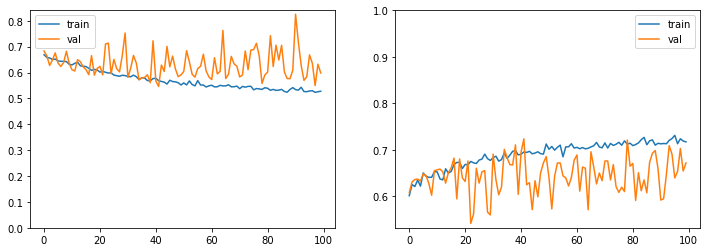

In [9]:
y = np.array([mrk.photo_reqs.looking_away.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'looking_away')
list_model_files.append(model_file)

#### 4. Ink Marked/Creased

In [10]:
y = np.array([mrk.photo_reqs.ink_marked_creased.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'ink_marked_creased')
list_model_files.append(model_file)

the requirement ink_marked_creased has only one label.


#### 5. Unnatural Skin Tone 

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6595 - accuracy: 0.5946 - precision: 0.5381 - recall: 0.6404 - f1: 0.5545 - specificity: 0.5545 - negative_predictive_value: 0.6840 - matthews_correlation_coefficient: 0.2138 - val_loss: 0.6252 - val_accuracy: 0.6618 - val_precision: 0.5894 - val_recall: 0.9021 - val_f1: 0.7061 - val_specificity: 0.4609 - val_negative_predictive_value: 0.8192 - val_matthews_correlation_coefficient: 0.3833

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.38334, saving model to ../models/autoencoders_requirements/unnatural_skin_tone_2020_03_24-12_58_30.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6150 - accuracy: 0.6614 - precision: 0.6010 - recall: 0.7234 - f1: 0.6271 - specificity: 0.6145 - negative_predictive_value: 0.7644 - matthews_correlation_coefficient: 0.3491 - val_loss: 0.5810 - val_accuracy: 0.6990 - val_pr


Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.46563
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5047 - accuracy: 0.7228 - precision: 0.6491 - recall: 0.8299 - f1: 0.7213 - specificity: 0.6368 - negative_predictive_value: 0.8172 - matthews_correlation_coefficient: 0.4678 - val_loss: 0.5240 - val_accuracy: 0.7407 - val_precision: 0.6979 - val_recall: 0.7717 - val_f1: 0.7256 - val_specificity: 0.7076 - val_negative_predictive_value: 0.7676 - val_matthews_correlation_coefficient: 0.4719

Epoch 00015: val_matthews_correlation_coefficient improved from 0.46563 to 0.47193, saving model to ../models/autoencoders_requirements/unnatural_skin_tone_2020_03_24-12_58_30.h5
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5031 - accuracy: 0.7295 - precision: 0.6663 - recall: 0.8029 - f1: 0.7174 - specificity: 0.6711 - negative_predictive_value: 0.8077 - matthews_correlation_coefficient: 0.4753 - val_loss: 0


Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.47193
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4934 - accuracy: 0.7377 - precision: 0.6710 - recall: 0.8089 - f1: 0.7222 - specificity: 0.6839 - negative_predictive_value: 0.8224 - matthews_correlation_coefficient: 0.4941 - val_loss: 0.5080 - val_accuracy: 0.7563 - val_precision: 0.7258 - val_recall: 0.7517 - val_f1: 0.7331 - val_specificity: 0.7492 - val_negative_predictive_value: 0.7630 - val_matthews_correlation_coefficient: 0.4945

Epoch 00030: val_matthews_correlation_coefficient improved from 0.47193 to 0.49452, saving model to ../models/autoencoders_requirements/unnatural_skin_tone_2020_03_24-12_58_30.h5
Epoch 31/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4922 - accuracy: 0.7330 - precision: 0.6634 - recall: 0.8038 - f1: 0.7156 - specificity: 0.6802 - negative_predictive_value: 0.8160 - matthews_correlation_coefficient: 0.4829 - val_loss: 0

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4831 - accuracy: 0.7512 - precision: 0.6893 - recall: 0.8035 - f1: 0.7297 - specificity: 0.7018 - negative_predictive_value: 0.8244 - matthews_correlation_coefficient: 0.5158 - val_loss: 0.5183 - val_accuracy: 0.7199 - val_precision: 0.6427 - val_recall: 0.8848 - val_f1: 0.7372 - val_specificity: 0.5782 - val_negative_predictive_value: 0.8374 - val_matthews_correlation_coefficient: 0.4704

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.49452
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4710 - accuracy: 0.7551 - precision: 0.6991 - recall: 0.8083 - f1: 0.7399 - specificity: 0.7083 - negative_predictive_value: 0.8208 - matthews_correlation_coefficient: 0.5177 - val_loss: 0.5375 - val_accuracy: 0.7277 - val_precision: 0.6511 - val_recall: 0.8717 - val_f1: 0.7388 - val_specificity: 0.6028 - val_negative_predictive_value: 0.8290 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4500 - accuracy: 0.7753 - precision: 0.7195 - recall: 0.8074 - f1: 0.7516 - specificity: 0.7461 - negative_predictive_value: 0.8349 - matthews_correlation_coefficient: 0.5550 - val_loss: 0.4931 - val_accuracy: 0.7563 - val_precision: 0.7191 - val_recall: 0.7690 - val_f1: 0.7378 - val_specificity: 0.7334 - val_negative_predictive_value: 0.7706 - val_matthews_correlation_coefficient: 0.4957

Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.51274
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4515 - accuracy: 0.7731 - precision: 0.7137 - recall: 0.8049 - f1: 0.7480 - specificity: 0.7469 - negative_predictive_value: 0.8334 - matthews_correlation_coefficient: 0.5507 - val_loss: 0.4955 - val_accuracy: 0.7537 - val_precision: 0.6861 - val_recall: 0.8384 - val_f1: 0.7493 - val_specificity: 0.6727 - val_negative_predictive_value: 0.8160 - val_matthews_correlation_coefficie


Epoch 00072: val_matthews_correlation_coefficient did not improve from 0.51821
Epoch 73/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4397 - accuracy: 0.7792 - precision: 0.7259 - recall: 0.8126 - f1: 0.7585 - specificity: 0.7518 - negative_predictive_value: 0.8387 - matthews_correlation_coefficient: 0.5660 - val_loss: 0.5059 - val_accuracy: 0.7598 - val_precision: 0.7002 - val_recall: 0.8243 - val_f1: 0.7514 - val_specificity: 0.6959 - val_negative_predictive_value: 0.8072 - val_matthews_correlation_coefficient: 0.5133

Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.51821
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4358 - accuracy: 0.7800 - precision: 0.7268 - recall: 0.8090 - f1: 0.7553 - specificity: 0.7567 - negative_predictive_value: 0.8365 - matthews_correlation_coefficient: 0.5638 - val_loss: 0.4877 - val_accuracy: 0.7537 - val_precision: 0.6986 - val_recall: 0.8095 - val_f1: 0.7440 - val_spe


Epoch 00087: val_matthews_correlation_coefficient did not improve from 0.52850
Epoch 88/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4315 - accuracy: 0.7822 - precision: 0.7251 - recall: 0.8128 - f1: 0.7574 - specificity: 0.7560 - negative_predictive_value: 0.8433 - matthews_correlation_coefficient: 0.5699 - val_loss: 0.5368 - val_accuracy: 0.7363 - val_precision: 0.6898 - val_recall: 0.7702 - val_f1: 0.7212 - val_specificity: 0.6984 - val_negative_predictive_value: 0.7667 - val_matthews_correlation_coefficient: 0.4622

Epoch 00088: val_matthews_correlation_coefficient did not improve from 0.52850
Epoch 89/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4328 - accuracy: 0.7837 - precision: 0.7353 - recall: 0.8016 - f1: 0.7557 - specificity: 0.7675 - negative_predictive_value: 0.8395 - matthews_correlation_coefficient: 0.5714 - val_loss: 0.5208 - val_accuracy: 0.7598 - val_precision: 0.7112 - val_recall: 0.7947 - val_f1: 0.7453 - val_spe

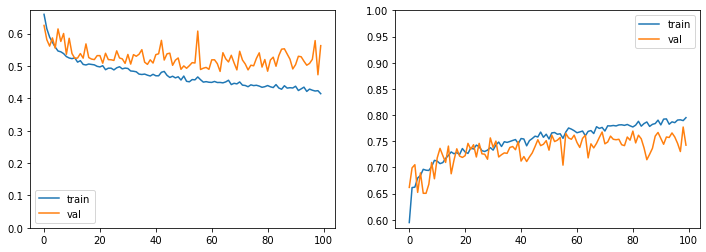

In [11]:
y = np.array([mrk.photo_reqs.unnatural_skin_tone.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'unnatural_skin_tone')
list_model_files.append(model_file)

#### 6. Too Dark/Light 

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6326 - accuracy: 0.6544 - precision: 0.9311 - recall: 0.6525 - f1: 0.7351 - specificity: 0.6445 - negative_predictive_value: 0.1968 - matthews_correlation_coefficient: 0.2068 - val_loss: 0.7055 - val_accuracy: 0.5299 - val_precision: 0.9684 - val_recall: 0.5055 - val_f1: 0.6580 - val_specificity: 0.7545 - val_negative_predictive_value: 0.1525 - val_matthews_correlation_coefficient: 0.1872

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.18718, saving model to ../models/autoencoders_requirements/too_dark_light_2020_03_24-13_13_00.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5589 - accuracy: 0.7015 - precision: 0.9616 - recall: 0.7009 - f1: 0.7942 - specificity: 0.7276 - negative_predictive_value: 0.2529 - matthews_correlation_coefficient: 0.2962 - val_loss: 0.4059 - val_accuracy: 0.8343 - val_precisi

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4456 - accuracy: 0.7839 - precision: 0.9727 - recall: 0.7842 - f1: 0.8639 - specificity: 0.7799 - negative_predictive_value: 0.3045 - matthews_correlation_coefficient: 0.3868 - val_loss: 0.3663 - val_accuracy: 0.8378 - val_precision: 0.9694 - val_recall: 0.8499 - val_f1: 0.9047 - val_specificity: 0.6752 - val_negative_predictive_value: 0.3334 - val_matthews_correlation_coefficient: 0.3974

Epoch 00015: val_matthews_correlation_coefficient improved from 0.36641 to 0.39739, saving model to ../models/autoencoders_requirements/too_dark_light_2020_03_24-13_13_00.h5
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4450 - accuracy: 0.7805 - precision: 0.9720 - recall: 0.7779 - f1: 0.8595 - specificity: 0.7789 - negative_predictive_value: 0.3023 - matthews_correlation_coefficient: 0.3834 - val_loss: 0.5751 - val_accuracy: 0.7042 - val_precision: 0.9862 - val_recall: 0.6883 - val_f1: 0.8077 - val_s


Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.39739
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4159 - accuracy: 0.7965 - precision: 0.9666 - recall: 0.7911 - f1: 0.8672 - specificity: 0.7819 - negative_predictive_value: 0.3151 - matthews_correlation_coefficient: 0.3977 - val_loss: 0.5933 - val_accuracy: 0.6982 - val_precision: 0.9851 - val_recall: 0.6829 - val_f1: 0.8041 - val_specificity: 0.7946 - val_negative_predictive_value: 0.2259 - val_matthews_correlation_coefficient: 0.3206

Epoch 00030: val_matthews_correlation_coefficient did not improve from 0.39739
Epoch 31/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4081 - accuracy: 0.7974 - precision: 0.9768 - recall: 0.7962 - f1: 0.8744 - specificity: 0.7711 - negative_predictive_value: 0.3115 - matthews_correlation_coefficient: 0.3990 - val_loss: 0.5410 - val_accuracy: 0.7372 - val_precision: 0.9821 - val_recall: 0.7277 - val_f1: 0.8337 - val_spe


Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.39739
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3841 - accuracy: 0.8213 - precision: 0.9760 - recall: 0.8201 - f1: 0.8892 - specificity: 0.7815 - negative_predictive_value: 0.3405 - matthews_correlation_coefficient: 0.4304 - val_loss: 0.5183 - val_accuracy: 0.7606 - val_precision: 0.9853 - val_recall: 0.7508 - val_f1: 0.8498 - val_specificity: 0.7892 - val_negative_predictive_value: 0.2625 - val_matthews_correlation_coefficient: 0.3648
Restoring model weights from the end of the best epoch

Epoch 00045: val_matthews_correlation_coefficient did not improve from 0.39739
Epoch 00045: early stopping

   Final Accuracy:  83.78%
  Final Precision:  96.91%
     Final Recall:  84.65%
  Final F-measure:  90.37%
Final Specificity:  76.07%
        Final NPV:  35.89%
        Final MCC:  44.62%
[[ 89  28]
 [159 877]]
              precision    recall  f1-score   support

           0     

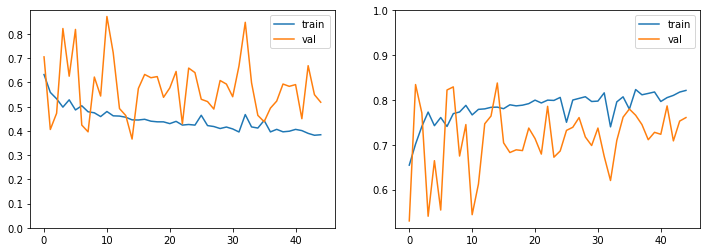

In [12]:
y = np.array([mrk.photo_reqs.too_dark_light.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'too_dark_light')
list_model_files.append(model_file)

#### 7. Washed Out

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5843 - accuracy: 0.7649 - precision: 0.9958 - recall: 0.7685 - f1: 0.8576 - specificity: 0.1207 - negative_predictive_value: 0.0195 - matthews_correlation_coefficient: 0.0348 - val_loss: 0.4972 - val_accuracy: 0.6973 - val_precision: 0.9986 - val_recall: 0.7035 - val_f1: 0.8231 - val_specificity: 0.1757 - val_negative_predictive_value: 0.0199 - val_matthews_correlation_coefficient: 0.0459

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.04587, saving model to ../models/autoencoders_requirements/washed_out_2020_03_24-13_19_39.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4755 - accuracy: 0.7638 - precision: 0.9982 - recall: 0.7648 - f1: 0.8572 - specificity: 0.1724 - negative_predictive_value: 0.0300 - matthews_correlation_coefficient: 0.0558 - val_loss: 0.2370 - val_accuracy: 0.8491 - val_precision: 

4610/4610 [==============================] - 9s 2ms/step - loss: 0.2691 - accuracy: 0.9245 - precision: 0.9986 - recall: 0.9257 - f1: 0.9586 - specificity: 0.2034 - negative_predictive_value: 0.1163 - matthews_correlation_coefficient: 0.1389 - val_loss: 0.2162 - val_accuracy: 0.9419 - val_precision: 0.9973 - val_recall: 0.9454 - val_f1: 0.9703 - val_specificity: 0.1216 - val_negative_predictive_value: 0.0649 - val_matthews_correlation_coefficient: 0.0807

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.10138
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2273 - accuracy: 0.9688 - precision: 0.9984 - recall: 0.9702 - f1: 0.9838 - specificity: 0.2069 - negative_predictive_value: 0.1475 - matthews_correlation_coefficient: 0.1656 - val_loss: 0.1705 - val_accuracy: 0.9662 - val_precision: 0.9973 - val_recall: 0.9693 - val_f1: 0.9829 - val_specificity: 0.1216 - val_negative_predictive_value: 0.0878 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.2600 - accuracy: 0.9555 - precision: 0.9985 - recall: 0.9539 - f1: 0.9731 - specificity: 0.1862 - negative_predictive_value: 0.1536 - matthews_correlation_coefficient: 0.1640 - val_loss: 0.3294 - val_accuracy: 0.8317 - val_precision: 0.9979 - val_recall: 0.8363 - val_f1: 0.9084 - val_specificity: 0.1486 - val_negative_predictive_value: 0.0269 - val_matthews_correlation_coefficient: 0.0523

Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.11868
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2412 - accuracy: 0.9028 - precision: 0.9988 - recall: 0.9036 - f1: 0.9459 - specificity: 0.2069 - negative_predictive_value: 0.0933 - matthews_correlation_coefficient: 0.1221 - val_loss: 0.1302 - val_accuracy: 0.9835 - val_precision: 0.9974 - val_recall: 0.9863 - val_f1: 0.9917 - val_specificity: 0.1216 - val_negative_predictive_value: 0.0946 - val_matthews_correlation_coefficie


Epoch 00043: val_matthews_correlation_coefficient improved from 0.12072 to 0.12457, saving model to ../models/autoencoders_requirements/washed_out_2020_03_24-13_19_39.h5
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2262 - accuracy: 0.9581 - precision: 0.9986 - recall: 0.9593 - f1: 0.9777 - specificity: 0.1931 - negative_predictive_value: 0.1229 - matthews_correlation_coefficient: 0.1449 - val_loss: 0.1059 - val_accuracy: 0.9870 - val_precision: 0.9974 - val_recall: 0.9897 - val_f1: 0.9935 - val_specificity: 0.1216 - val_negative_predictive_value: 0.0991 - val_matthews_correlation_coefficient: 0.1072

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.12457
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2085 - accuracy: 0.9764 - precision: 0.9987 - recall: 0.9776 - f1: 0.9878 - specificity: 0.2207 - negative_predictive_value: 0.1600 - matthews_correlation_coefficient: 0.1805 - val_loss: 0.2264 - v

4610/4610 [==============================] - 9s 2ms/step - loss: 0.2047 - accuracy: 0.9642 - precision: 0.9988 - recall: 0.9651 - f1: 0.9812 - specificity: 0.2138 - negative_predictive_value: 0.1377 - matthews_correlation_coefficient: 0.1612 - val_loss: 0.3280 - val_accuracy: 0.8448 - val_precision: 0.9980 - val_recall: 0.8492 - val_f1: 0.9162 - val_specificity: 0.1486 - val_negative_predictive_value: 0.0367 - val_matthews_correlation_coefficient: 0.0627

Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.12746
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1755 - accuracy: 0.9377 - precision: 0.9991 - recall: 0.9385 - f1: 0.9672 - specificity: 0.2103 - negative_predictive_value: 0.0998 - matthews_correlation_coefficient: 0.1355 - val_loss: 0.1804 - val_accuracy: 0.9506 - val_precision: 0.9981 - val_recall: 0.9530 - val_f1: 0.9747 - val_specificity: 0.1486 - val_negative_predictive_value: 0.0901 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.1766 - accuracy: 0.9521 - precision: 0.9991 - recall: 0.9528 - f1: 0.9746 - specificity: 0.2138 - negative_predictive_value: 0.1239 - matthews_correlation_coefficient: 0.1510 - val_loss: 0.2286 - val_accuracy: 0.9350 - val_precision: 0.9981 - val_recall: 0.9377 - val_f1: 0.9665 - val_specificity: 0.1486 - val_negative_predictive_value: 0.0888 - val_matthews_correlation_coefficient: 0.1055

Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.12746
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1721 - accuracy: 0.9584 - precision: 0.9989 - recall: 0.9562 - f1: 0.9761 - specificity: 0.2011 - negative_predictive_value: 0.1385 - matthews_correlation_coefficient: 0.1592 - val_loss: 0.3116 - val_accuracy: 0.8552 - val_precision: 0.9709 - val_recall: 0.8332 - val_f1: 0.8954 - val_specificity: 0.1486 - val_negative_predictive_value: 0.0524 - val_matthews_correlation_coefficie

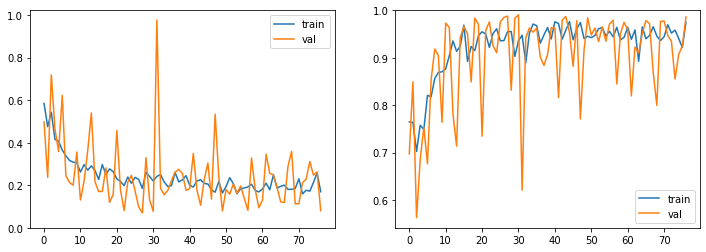

In [13]:
y = np.array([mrk.photo_reqs.washed_out.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'washed_out')
list_model_files.append(model_file)

#### 8. Pixelation

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6720 - accuracy: 0.5618 - precision: 0.9419 - recall: 0.5540 - f1: 0.6812 - specificity: 0.6021 - negative_predictive_value: 0.1071 - matthews_correlation_coefficient: 0.1161 - val_loss: 0.7908 - val_accuracy: 0.4683 - val_precision: 0.9709 - val_recall: 0.4585 - val_f1: 0.6140 - val_specificity: 0.6748 - val_negative_predictive_value: 0.0923 - val_matthews_correlation_coefficient: 0.1072

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.10719, saving model to ../models/autoencoders_requirements/pixelation_2020_03_24-13_31_08.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6389 - accuracy: 0.6256 - precision: 0.9656 - recall: 0.6241 - f1: 0.7475 - specificity: 0.5887 - negative_predictive_value: 0.1259 - matthews_correlation_coefficient: 0.1495 - val_loss: 0.5257 - val_accuracy: 0.7303 - val_precision: 

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5302 - accuracy: 0.7163 - precision: 0.9767 - recall: 0.7128 - f1: 0.8196 - specificity: 0.6745 - negative_predictive_value: 0.1694 - matthews_correlation_coefficient: 0.2398 - val_loss: 0.4949 - val_accuracy: 0.7129 - val_precision: 0.9707 - val_recall: 0.7219 - val_f1: 0.8249 - val_specificity: 0.5712 - val_negative_predictive_value: 0.1410 - val_matthews_correlation_coefficient: 0.1830

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.23497
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5111 - accuracy: 0.7161 - precision: 0.9764 - recall: 0.7148 - f1: 0.8215 - specificity: 0.6813 - negative_predictive_value: 0.1617 - matthews_correlation_coefficient: 0.2361 - val_loss: 0.3276 - val_accuracy: 0.8118 - val_precision: 0.9600 - val_recall: 0.8372 - val_f1: 0.8926 - val_specificity: 0.4239 - val_negative_predictive_value: 0.1787 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4910 - accuracy: 0.7187 - precision: 0.9717 - recall: 0.7105 - f1: 0.8172 - specificity: 0.6948 - negative_predictive_value: 0.1707 - matthews_correlation_coefficient: 0.2421 - val_loss: 0.5142 - val_accuracy: 0.7199 - val_precision: 0.9698 - val_recall: 0.7305 - val_f1: 0.8304 - val_specificity: 0.5725 - val_negative_predictive_value: 0.1472 - val_matthews_correlation_coefficient: 0.1898

Epoch 00030: val_matthews_correlation_coefficient did not improve from 0.23497
Epoch 31/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6254 - accuracy: 0.6852 - precision: 0.9673 - recall: 0.6853 - f1: 0.7776 - specificity: 0.6789 - negative_predictive_value: 0.1652 - matthews_correlation_coefficient: 0.2294 - val_loss: 0.2903 - val_accuracy: 0.8812 - val_precision: 0.9487 - val_recall: 0.9257 - val_f1: 0.9364 - val_specificity: 0.2410 - val_negative_predictive_value: 0.1820 - val_matthews_correlation_coefficie

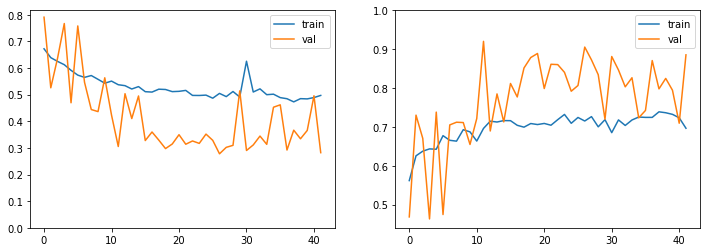

In [14]:
y = np.array([mrk.photo_reqs.pixelation.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'pixelation')
list_model_files.append(model_file)

#### 9. Hair Across Eyes 

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5302 - accuracy: 0.6770 - precision: 0.9739 - recall: 0.6568 - f1: 0.7800 - specificity: 0.8615 - negative_predictive_value: 0.2529 - matthews_correlation_coefficient: 0.3369 - val_loss: 0.5870 - val_accuracy: 0.6427 - val_precision: 0.9558 - val_recall: 0.5901 - val_f1: 0.7270 - val_specificity: 0.9048 - val_negative_predictive_value: 0.2493 - val_matthews_correlation_coefficient: 0.3145

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.31454, saving model to ../models/autoencoders_requirements/hair_across_eyes_2020_03_24-13_37_23.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4963 - accuracy: 0.6772 - precision: 0.9825 - recall: 0.6501 - f1: 0.7791 - specificity: 0.8672 - negative_predictive_value: 0.2465 - matthews_correlation_coefficient: 0.3390 - val_loss: 0.4777 - val_accuracy: 0.6696 - val_preci


Epoch 00014: val_matthews_correlation_coefficient improved from 0.41372 to 0.51312, saving model to ../models/autoencoders_requirements/hair_across_eyes_2020_03_24-13_37_23.h5
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3940 - accuracy: 0.8193 - precision: 0.9783 - recall: 0.8158 - f1: 0.8859 - specificity: 0.8606 - negative_predictive_value: 0.3955 - matthews_correlation_coefficient: 0.4924 - val_loss: 0.6748 - val_accuracy: 0.6800 - val_precision: 0.9579 - val_recall: 0.6305 - val_f1: 0.7578 - val_specificity: 0.9184 - val_negative_predictive_value: 0.2728 - val_matthews_correlation_coefficient: 0.3508

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.51312
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3885 - accuracy: 0.8165 - precision: 0.9810 - recall: 0.8097 - f1: 0.8836 - specificity: 0.8538 - negative_predictive_value: 0.3885 - matthews_correlation_coefficient: 0.4865 - val_loss: 0.34

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3625 - accuracy: 0.8432 - precision: 0.9805 - recall: 0.8406 - f1: 0.9024 - specificity: 0.8529 - negative_predictive_value: 0.4272 - matthews_correlation_coefficient: 0.5225 - val_loss: 0.2799 - val_accuracy: 0.8794 - val_precision: 0.9369 - val_recall: 0.8717 - val_f1: 0.9025 - val_specificity: 0.7475 - val_negative_predictive_value: 0.4863 - val_matthews_correlation_coefficient: 0.5043

Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.52474
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3622 - accuracy: 0.8438 - precision: 0.9788 - recall: 0.8400 - f1: 0.9011 - specificity: 0.8655 - negative_predictive_value: 0.4246 - matthews_correlation_coefficient: 0.5282 - val_loss: 0.5424 - val_accuracy: 0.7684 - val_precision: 0.9582 - val_recall: 0.7279 - val_f1: 0.8259 - val_specificity: 0.9145 - val_negative_predictive_value: 0.3325 - val_matthews_correlation_coefficie


Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.53942
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3421 - accuracy: 0.8594 - precision: 0.9830 - recall: 0.8576 - f1: 0.9141 - specificity: 0.8425 - negative_predictive_value: 0.4519 - matthews_correlation_coefficient: 0.5448 - val_loss: 0.3242 - val_accuracy: 0.8690 - val_precision: 0.9456 - val_recall: 0.8517 - val_f1: 0.8954 - val_specificity: 0.8079 - val_negative_predictive_value: 0.4713 - val_matthews_correlation_coefficient: 0.5161

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.53942
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3379 - accuracy: 0.8505 - precision: 0.9829 - recall: 0.8471 - f1: 0.9078 - specificity: 0.8803 - negative_predictive_value: 0.4370 - matthews_correlation_coefficient: 0.5431 - val_loss: 0.3371 - val_accuracy: 0.8682 - val_precision: 0.9516 - val_recall: 0.8452 - val_f1: 0.8945 - val_spe


Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.53942
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3281 - accuracy: 0.8542 - precision: 0.9849 - recall: 0.8493 - f1: 0.9094 - specificity: 0.8866 - negative_predictive_value: 0.4571 - matthews_correlation_coefficient: 0.5601 - val_loss: 0.4681 - val_accuracy: 0.8309 - val_precision: 0.9551 - val_recall: 0.8007 - val_f1: 0.8696 - val_specificity: 0.8762 - val_negative_predictive_value: 0.4158 - val_matthews_correlation_coefficient: 0.4918

Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.53942
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3183 - accuracy: 0.8592 - precision: 0.9847 - recall: 0.8556 - f1: 0.9137 - specificity: 0.9017 - negative_predictive_value: 0.4542 - matthews_correlation_coefficient: 0.5664 - val_loss: 0.3738 - val_accuracy: 0.8517 - val_precision: 0.9556 - val_recall: 0.8237 - val_f1: 0.8836 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3145 - accuracy: 0.8614 - precision: 0.9842 - recall: 0.8586 - f1: 0.9154 - specificity: 0.8659 - negative_predictive_value: 0.4486 - matthews_correlation_coefficient: 0.5508 - val_loss: 0.3772 - val_accuracy: 0.8526 - val_precision: 0.9533 - val_recall: 0.8261 - val_f1: 0.8836 - val_specificity: 0.8640 - val_negative_predictive_value: 0.4547 - val_matthews_correlation_coefficient: 0.5237

Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.54510
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3126 - accuracy: 0.8664 - precision: 0.9853 - recall: 0.8597 - f1: 0.9164 - specificity: 0.8755 - negative_predictive_value: 0.4517 - matthews_correlation_coefficient: 0.5588 - val_loss: 0.3982 - val_accuracy: 0.8491 - val_precision: 0.9556 - val_recall: 0.8205 - val_f1: 0.8816 - val_specificity: 0.8821 - val_negative_predictive_value: 0.4398 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.2956 - accuracy: 0.8705 - precision: 0.9851 - recall: 0.8672 - f1: 0.9208 - specificity: 0.8867 - negative_predictive_value: 0.4766 - matthews_correlation_coefficient: 0.5824 - val_loss: 0.2988 - val_accuracy: 0.8838 - val_precision: 0.9469 - val_recall: 0.8667 - val_f1: 0.9043 - val_specificity: 0.8144 - val_negative_predictive_value: 0.5144 - val_matthews_correlation_coefficient: 0.5533

Epoch 00087: val_matthews_correlation_coefficient improved from 0.54705 to 0.55330, saving model to ../models/autoencoders_requirements/hair_across_eyes_2020_03_24-13_37_23.h5
Epoch 88/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2932 - accuracy: 0.8720 - precision: 0.9876 - recall: 0.8643 - f1: 0.9195 - specificity: 0.9016 - negative_predictive_value: 0.4807 - matthews_correlation_coefficient: 0.5883 - val_loss: 0.3090 - val_accuracy: 0.8794 - val_precision: 0.9468 - val_recall: 0.8619 - val_f1: 0.9015 - val

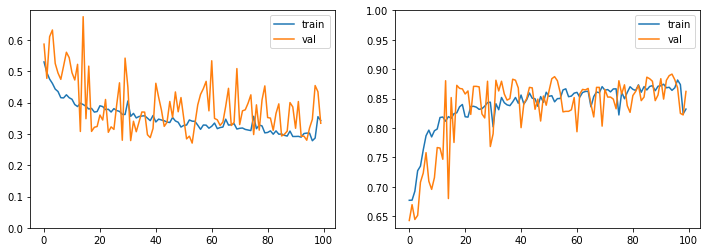

In [15]:
y = np.array([mrk.photo_reqs.hair_across_eyes.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'hair_across_eyes')
list_model_files.append(model_file)

#### 10. Eyes Closed  

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 11s 2ms/step - loss: 0.6377 - accuracy: 0.5328 - precision: 0.9088 - recall: 0.4633 - f1: 0.6029 - specificity: 0.8016 - negative_predictive_value: 0.2825 - matthews_correlation_coefficient: 0.2244 - val_loss: 0.6928 - val_accuracy: 0.4840 - val_precision: 0.9276 - val_recall: 0.3955 - val_f1: 0.5423 - val_specificity: 0.8581 - val_negative_predictive_value: 0.2663 - val_matthews_correlation_coefficient: 0.2197

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.21970, saving model to ../models/autoencoders_requirements/eyes_closed_2020_03_24-13_52_04.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6301 - accuracy: 0.5349 - precision: 0.9202 - recall: 0.4535 - f1: 0.5994 - specificity: 0.8305 - negative_predictive_value: 0.2864 - matthews_correlation_coefficient: 0.2423 - val_loss: 0.6406 - val_accuracy: 0.5048 - val_precision

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5853 - accuracy: 0.6360 - precision: 0.9230 - recall: 0.5972 - f1: 0.7167 - specificity: 0.7991 - negative_predictive_value: 0.3472 - matthews_correlation_coefficient: 0.3261 - val_loss: 0.6507 - val_accuracy: 0.5898 - val_precision: 0.9328 - val_recall: 0.5310 - val_f1: 0.6692 - val_specificity: 0.8393 - val_negative_predictive_value: 0.3159 - val_matthews_correlation_coefficient: 0.3019

Epoch 00015: val_matthews_correlation_coefficient improved from 0.29851 to 0.30188, saving model to ../models/autoencoders_requirements/eyes_closed_2020_03_24-13_52_04.h5
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5761 - accuracy: 0.6588 - precision: 0.9218 - recall: 0.6235 - f1: 0.7365 - specificity: 0.7861 - negative_predictive_value: 0.3570 - matthews_correlation_coefficient: 0.3363 - val_loss: 0.5443 - val_accuracy: 0.6895 - val_precision: 0.9049 - val_recall: 0.6926 - val_f1: 0.7800 - val_spec

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5422 - accuracy: 0.6839 - precision: 0.9259 - recall: 0.6539 - f1: 0.7608 - specificity: 0.7722 - negative_predictive_value: 0.3750 - matthews_correlation_coefficient: 0.3588 - val_loss: 0.6030 - val_accuracy: 0.6618 - val_precision: 0.9155 - val_recall: 0.6420 - val_f1: 0.7505 - val_specificity: 0.7482 - val_negative_predictive_value: 0.3465 - val_matthews_correlation_coefficient: 0.3181

Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.34278
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5491 - accuracy: 0.6831 - precision: 0.9124 - recall: 0.6582 - f1: 0.7561 - specificity: 0.7704 - negative_predictive_value: 0.3788 - matthews_correlation_coefficient: 0.3508 - val_loss: 0.6707 - val_accuracy: 0.6149 - val_precision: 0.9193 - val_recall: 0.5770 - val_f1: 0.7021 - val_specificity: 0.7811 - val_negative_predictive_value: 0.3220 - val_matthews_correlation_coefficie


Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.34952
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5272 - accuracy: 0.6972 - precision: 0.9203 - recall: 0.6680 - f1: 0.7669 - specificity: 0.7881 - negative_predictive_value: 0.3990 - matthews_correlation_coefficient: 0.3817 - val_loss: 0.6042 - val_accuracy: 0.6184 - val_precision: 0.9316 - val_recall: 0.5721 - val_f1: 0.7012 - val_specificity: 0.8160 - val_negative_predictive_value: 0.3282 - val_matthews_correlation_coefficient: 0.3157

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.34952
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5326 - accuracy: 0.6935 - precision: 0.9249 - recall: 0.6722 - f1: 0.7710 - specificity: 0.7908 - negative_predictive_value: 0.3964 - matthews_correlation_coefficient: 0.3822 - val_loss: 0.4950 - val_accuracy: 0.7181 - val_precision: 0.8979 - val_recall: 0.7368 - val_f1: 0.8059 - val_spe


Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.35281
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5123 - accuracy: 0.7108 - precision: 0.9264 - recall: 0.6920 - f1: 0.7869 - specificity: 0.7963 - negative_predictive_value: 0.4126 - matthews_correlation_coefficient: 0.4035 - val_loss: 0.5761 - val_accuracy: 0.6817 - val_precision: 0.9237 - val_recall: 0.6624 - val_f1: 0.7658 - val_specificity: 0.7711 - val_negative_predictive_value: 0.3728 - val_matthews_correlation_coefficient: 0.3568

Epoch 00059: val_matthews_correlation_coefficient improved from 0.35281 to 0.35680, saving model to ../models/autoencoders_requirements/eyes_closed_2020_03_24-13_52_04.h5
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5105 - accuracy: 0.7082 - precision: 0.9326 - recall: 0.6861 - f1: 0.7831 - specificity: 0.8026 - negative_predictive_value: 0.4112 - matthews_correlation_coefficient: 0.4064 - val_loss: 0.6641 - 

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5028 - accuracy: 0.7230 - precision: 0.9271 - recall: 0.7091 - f1: 0.7973 - specificity: 0.7746 - negative_predictive_value: 0.4111 - matthews_correlation_coefficient: 0.4008 - val_loss: 0.5750 - val_accuracy: 0.6730 - val_precision: 0.9262 - val_recall: 0.6485 - val_f1: 0.7586 - val_specificity: 0.7767 - val_negative_predictive_value: 0.3599 - val_matthews_correlation_coefficient: 0.3469

Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.35828
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5164 - accuracy: 0.7119 - precision: 0.9246 - recall: 0.6971 - f1: 0.7860 - specificity: 0.7718 - negative_predictive_value: 0.4089 - matthews_correlation_coefficient: 0.3921 - val_loss: 0.6311 - val_accuracy: 0.6487 - val_precision: 0.9281 - val_recall: 0.6141 - val_f1: 0.7338 - val_specificity: 0.7966 - val_negative_predictive_value: 0.3468 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4891 - accuracy: 0.7243 - precision: 0.9307 - recall: 0.7089 - f1: 0.7980 - specificity: 0.7958 - negative_predictive_value: 0.4203 - matthews_correlation_coefficient: 0.4168 - val_loss: 0.6980 - val_accuracy: 0.6184 - val_precision: 0.9411 - val_recall: 0.5652 - val_f1: 0.6995 - val_specificity: 0.8385 - val_negative_predictive_value: 0.3316 - val_matthews_correlation_coefficient: 0.3299

Epoch 00088: val_matthews_correlation_coefficient did not improve from 0.35828
Epoch 89/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4947 - accuracy: 0.7262 - precision: 0.9288 - recall: 0.7129 - f1: 0.7994 - specificity: 0.7952 - negative_predictive_value: 0.4341 - matthews_correlation_coefficient: 0.4251 - val_loss: 0.5582 - val_accuracy: 0.7060 - val_precision: 0.9119 - val_recall: 0.7076 - val_f1: 0.7937 - val_specificity: 0.7025 - val_negative_predictive_value: 0.3758 - val_matthews_correlation_coefficie

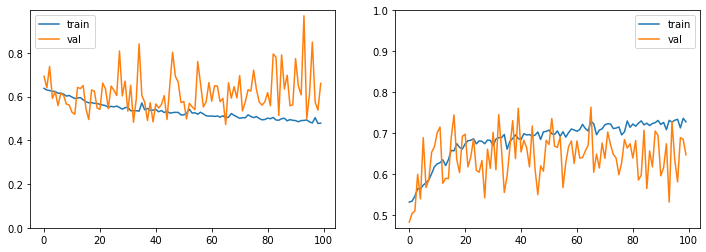

In [16]:
y = np.array([mrk.photo_reqs.eyes_closed.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'eyes_closed')
list_model_files.append(model_file)

#### 11. Varied Background

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5045 - accuracy: 0.7356 - precision: 0.8168 - recall: 0.7080 - f1: 0.7363 - specificity: 0.7803 - negative_predictive_value: 0.6959 - matthews_correlation_coefficient: 0.5010 - val_loss: 0.4117 - val_accuracy: 0.7884 - val_precision: 0.8400 - val_recall: 0.7750 - val_f1: 0.8010 - val_specificity: 0.7833 - val_negative_predictive_value: 0.7166 - val_matthews_correlation_coefficient: 0.5572

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.55718, saving model to ../models/autoencoders_requirements/varied_background_2020_03_24-14_06_56.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4319 - accuracy: 0.7666 - precision: 0.8250 - recall: 0.7677 - f1: 0.7793 - specificity: 0.7785 - negative_predictive_value: 0.7419 - matthews_correlation_coefficient: 0.5555 - val_loss: 0.3823 - val_accuracy: 0.8109 - val_prec


Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.65988
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3606 - accuracy: 0.8219 - precision: 0.8557 - recall: 0.8151 - f1: 0.8264 - specificity: 0.8328 - negative_predictive_value: 0.7917 - matthews_correlation_coefficient: 0.6489 - val_loss: 0.3268 - val_accuracy: 0.8430 - val_precision: 0.9040 - val_recall: 0.8127 - val_f1: 0.8527 - val_specificity: 0.8625 - val_negative_predictive_value: 0.7594 - val_matthews_correlation_coefficient: 0.6689

Epoch 00015: val_matthews_correlation_coefficient improved from 0.65988 to 0.66891, saving model to ../models/autoencoders_requirements/varied_background_2020_03_24-14_06_56.h5
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3605 - accuracy: 0.8187 - precision: 0.8587 - recall: 0.8020 - f1: 0.8209 - specificity: 0.8442 - negative_predictive_value: 0.7777 - matthews_correlation_coefficient: 0.6425 - val_loss: 0.3

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3196 - accuracy: 0.8416 - precision: 0.8854 - recall: 0.8300 - f1: 0.8515 - specificity: 0.8643 - negative_predictive_value: 0.8023 - matthews_correlation_coefficient: 0.6907 - val_loss: 0.2995 - val_accuracy: 0.8543 - val_precision: 0.9115 - val_recall: 0.8251 - val_f1: 0.8634 - val_specificity: 0.8736 - val_negative_predictive_value: 0.7724 - val_matthews_correlation_coefficient: 0.6910

Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.69914
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3325 - accuracy: 0.8336 - precision: 0.8733 - recall: 0.8179 - f1: 0.8366 - specificity: 0.8586 - negative_predictive_value: 0.7948 - matthews_correlation_coefficient: 0.6736 - val_loss: 0.2991 - val_accuracy: 0.8673 - val_precision: 0.8871 - val_recall: 0.8835 - val_f1: 0.8815 - val_specificity: 0.8290 - val_negative_predictive_value: 0.8243 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3092 - accuracy: 0.8512 - precision: 0.8875 - recall: 0.8457 - f1: 0.8615 - specificity: 0.8652 - negative_predictive_value: 0.8135 - matthews_correlation_coefficient: 0.7056 - val_loss: 0.3003 - val_accuracy: 0.8543 - val_precision: 0.9166 - val_recall: 0.8182 - val_f1: 0.8615 - val_specificity: 0.8814 - val_negative_predictive_value: 0.7705 - val_matthews_correlation_coefficient: 0.6929

Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.72199
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3105 - accuracy: 0.8518 - precision: 0.8933 - recall: 0.8438 - f1: 0.8624 - specificity: 0.8717 - negative_predictive_value: 0.8136 - matthews_correlation_coefficient: 0.7105 - val_loss: 0.2809 - val_accuracy: 0.8682 - val_precision: 0.8672 - val_recall: 0.9104 - val_f1: 0.8846 - val_specificity: 0.7976 - val_negative_predictive_value: 0.8513 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.2885 - accuracy: 0.8564 - precision: 0.8864 - recall: 0.8430 - f1: 0.8588 - specificity: 0.8679 - negative_predictive_value: 0.8168 - matthews_correlation_coefficient: 0.7065 - val_loss: 0.2814 - val_accuracy: 0.8621 - val_precision: 0.8971 - val_recall: 0.8565 - val_f1: 0.8729 - val_specificity: 0.8533 - val_negative_predictive_value: 0.7996 - val_matthews_correlation_coefficient: 0.7030

Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.72199
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3201 - accuracy: 0.8477 - precision: 0.8785 - recall: 0.8338 - f1: 0.8501 - specificity: 0.8655 - negative_predictive_value: 0.8115 - matthews_correlation_coefficient: 0.6961 - val_loss: 0.2852 - val_accuracy: 0.8569 - val_precision: 0.8439 - val_recall: 0.9208 - val_f1: 0.8771 - val_specificity: 0.7560 - val_negative_predictive_value: 0.8575 - val_matthews_correlation_coefficie


Epoch 00072: val_matthews_correlation_coefficient did not improve from 0.72679
Epoch 73/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2809 - accuracy: 0.8636 - precision: 0.8970 - recall: 0.8537 - f1: 0.8693 - specificity: 0.8750 - negative_predictive_value: 0.8236 - matthews_correlation_coefficient: 0.7259 - val_loss: 0.3042 - val_accuracy: 0.8482 - val_precision: 0.8102 - val_recall: 0.9598 - val_f1: 0.8760 - val_specificity: 0.6838 - val_negative_predictive_value: 0.9042 - val_matthews_correlation_coefficient: 0.6772

Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.72679
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2885 - accuracy: 0.8575 - precision: 0.8944 - recall: 0.8512 - f1: 0.8670 - specificity: 0.8694 - negative_predictive_value: 0.8270 - matthews_correlation_coefficient: 0.7207 - val_loss: 0.2660 - val_accuracy: 0.8682 - val_precision: 0.8919 - val_recall: 0.8733 - val_f1: 0.8796 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.2638 - accuracy: 0.8733 - precision: 0.8988 - recall: 0.8600 - f1: 0.8755 - specificity: 0.8789 - negative_predictive_value: 0.8322 - matthews_correlation_coefficient: 0.7346 - val_loss: 0.2846 - val_accuracy: 0.8647 - val_precision: 0.8800 - val_recall: 0.8815 - val_f1: 0.8777 - val_specificity: 0.8286 - val_negative_predictive_value: 0.8230 - val_matthews_correlation_coefficient: 0.7063

Epoch 00087: val_matthews_correlation_coefficient did not improve from 0.73067
Epoch 88/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2834 - accuracy: 0.8636 - precision: 0.8918 - recall: 0.8517 - f1: 0.8659 - specificity: 0.8727 - negative_predictive_value: 0.8325 - matthews_correlation_coefficient: 0.7257 - val_loss: 0.2722 - val_accuracy: 0.8699 - val_precision: 0.8566 - val_recall: 0.9266 - val_f1: 0.8872 - val_specificity: 0.7790 - val_negative_predictive_value: 0.8708 - val_matthews_correlation_coefficie

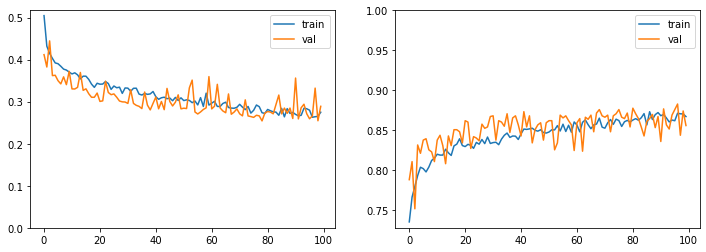

In [17]:
y = np.array([mrk.photo_reqs.varied_background.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'varied_background')
list_model_files.append(model_file)

#### 12. Roll/pitch/yaw

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5919 - accuracy: 0.6989 - precision: 0.8912 - recall: 0.6870 - f1: 0.7705 - specificity: 0.7422 - negative_predictive_value: 0.4388 - matthews_correlation_coefficient: 0.3754 - val_loss: 0.5657 - val_accuracy: 0.7069 - val_precision: 0.8857 - val_recall: 0.6595 - val_f1: 0.7506 - val_specificity: 0.8043 - val_negative_predictive_value: 0.4714 - val_matthews_correlation_coefficient: 0.4048

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.40478, saving model to ../models/autoencoders_requirements/roll_pitch_yaw_2020_03_24-14_21_38.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5824 - accuracy: 0.7017 - precision: 0.9021 - recall: 0.6787 - f1: 0.7709 - specificity: 0.7866 - negative_predictive_value: 0.4420 - matthews_correlation_coefficient: 0.3976 - val_loss: 0.5513 - val_accuracy: 0.7077 - val_precisi

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5675 - accuracy: 0.7063 - precision: 0.9083 - recall: 0.6757 - f1: 0.7710 - specificity: 0.7908 - negative_predictive_value: 0.4499 - matthews_correlation_coefficient: 0.4082 - val_loss: 0.6331 - val_accuracy: 0.7008 - val_precision: 0.8965 - val_recall: 0.6416 - val_f1: 0.7425 - val_specificity: 0.8376 - val_negative_predictive_value: 0.4661 - val_matthews_correlation_coefficient: 0.4146

Epoch 00015: val_matthews_correlation_coefficient improved from 0.41324 to 0.41457, saving model to ../models/autoencoders_requirements/roll_pitch_yaw_2020_03_24-14_21_38.h5
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5700 - accuracy: 0.7043 - precision: 0.9079 - recall: 0.6728 - f1: 0.7691 - specificity: 0.7936 - negative_predictive_value: 0.4457 - matthews_correlation_coefficient: 0.4056 - val_loss: 0.5629 - val_accuracy: 0.7051 - val_precision: 0.8888 - val_recall: 0.6536 - val_f1: 0.7479 - val_s

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5609 - accuracy: 0.7078 - precision: 0.9083 - recall: 0.6801 - f1: 0.7740 - specificity: 0.7851 - negative_predictive_value: 0.4495 - matthews_correlation_coefficient: 0.4079 - val_loss: 0.5799 - val_accuracy: 0.7008 - val_precision: 0.8950 - val_recall: 0.6426 - val_f1: 0.7421 - val_specificity: 0.8365 - val_negative_predictive_value: 0.4671 - val_matthews_correlation_coefficient: 0.4142

Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.41827
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5613 - accuracy: 0.7056 - precision: 0.9100 - recall: 0.6780 - f1: 0.7730 - specificity: 0.7913 - negative_predictive_value: 0.4472 - matthews_correlation_coefficient: 0.4075 - val_loss: 0.5365 - val_accuracy: 0.7112 - val_precision: 0.8876 - val_recall: 0.6640 - val_f1: 0.7540 - val_specificity: 0.8102 - val_negative_predictive_value: 0.4767 - val_matthews_correlation_coefficie


Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.42206
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5561 - accuracy: 0.7132 - precision: 0.9081 - recall: 0.6880 - f1: 0.7794 - specificity: 0.7876 - negative_predictive_value: 0.4548 - matthews_correlation_coefficient: 0.4137 - val_loss: 0.5205 - val_accuracy: 0.7225 - val_precision: 0.8691 - val_recall: 0.6969 - val_f1: 0.7697 - val_specificity: 0.7461 - val_negative_predictive_value: 0.4795 - val_matthews_correlation_coefficient: 0.3913

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.42206
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5574 - accuracy: 0.7148 - precision: 0.9046 - recall: 0.6913 - f1: 0.7794 - specificity: 0.7800 - negative_predictive_value: 0.4536 - matthews_correlation_coefficient: 0.4110 - val_loss: 0.5626 - val_accuracy: 0.7112 - val_precision: 0.8903 - val_recall: 0.6625 - val_f1: 0.7543 - val_spe


Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.42337
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5474 - accuracy: 0.7163 - precision: 0.9078 - recall: 0.6956 - f1: 0.7839 - specificity: 0.7848 - negative_predictive_value: 0.4587 - matthews_correlation_coefficient: 0.4181 - val_loss: 0.5423 - val_accuracy: 0.7259 - val_precision: 0.8752 - val_recall: 0.6966 - val_f1: 0.7713 - val_specificity: 0.7722 - val_negative_predictive_value: 0.4846 - val_matthews_correlation_coefficient: 0.4084

Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.42337
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5444 - accuracy: 0.7232 - precision: 0.9123 - recall: 0.7020 - f1: 0.7894 - specificity: 0.7901 - negative_predictive_value: 0.4675 - matthews_correlation_coefficient: 0.4302 - val_loss: 0.5679 - val_accuracy: 0.7008 - val_precision: 0.8891 - val_recall: 0.6446 - val_f1: 0.7436 - val_spe


Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.42337
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5437 - accuracy: 0.7226 - precision: 0.9120 - recall: 0.6998 - f1: 0.7888 - specificity: 0.7883 - negative_predictive_value: 0.4640 - matthews_correlation_coefficient: 0.4268 - val_loss: 0.5416 - val_accuracy: 0.7199 - val_precision: 0.8817 - val_recall: 0.6798 - val_f1: 0.7637 - val_specificity: 0.7899 - val_negative_predictive_value: 0.4813 - val_matthews_correlation_coefficient: 0.4110

Epoch 00074: val_matthews_correlation_coefficient did not improve from 0.42337
Epoch 75/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5387 - accuracy: 0.7210 - precision: 0.9099 - recall: 0.6972 - f1: 0.7849 - specificity: 0.7993 - negative_predictive_value: 0.4632 - matthews_correlation_coefficient: 0.4297 - val_loss: 0.6046 - val_accuracy: 0.6921 - val_precision: 0.8878 - val_recall: 0.6363 - val_f1: 0.7368 - val_spe

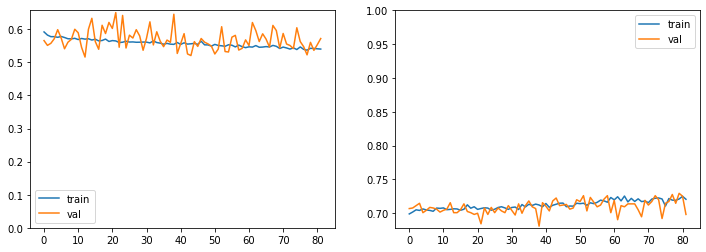

In [18]:
y = np.array([mrk.photo_reqs.roll_pitch_yaw.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'roll_pitch_yaw')
list_model_files.append(model_file)

#### 13. Flash Reflection on Skin

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6348 - accuracy: 0.6393 - precision: 0.6429 - recall: 0.6051 - f1: 0.5840 - specificity: 0.6613 - negative_predictive_value: 0.6640 - matthews_correlation_coefficient: 0.2858 - val_loss: 0.6000 - val_accuracy: 0.6470 - val_precision: 0.6506 - val_recall: 0.5638 - val_f1: 0.5961 - val_specificity: 0.7211 - val_negative_predictive_value: 0.6345 - val_matthews_correlation_coefficient: 0.2849

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.28485, saving model to ../models/autoencoders_requirements/flash_reflection_on_skin_2020_03_24-14_33_42.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6008 - accuracy: 0.6772 - precision: 0.6717 - recall: 0.7468 - f1: 0.6871 - specificity: 0.6235 - negative_predictive_value: 0.7192 - matthews_correlation_coefficient: 0.3797 - val_loss: 0.5849 - val_accuracy: 0.6843 - v

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4822 - accuracy: 0.7473 - precision: 0.7334 - recall: 0.7996 - f1: 0.7545 - specificity: 0.6965 - negative_predictive_value: 0.7758 - matthews_correlation_coefficient: 0.5040 - val_loss: 0.5031 - val_accuracy: 0.7190 - val_precision: 0.6479 - val_recall: 0.8292 - val_f1: 0.7215 - val_specificity: 0.5888 - val_negative_predictive_value: 0.8115 - val_matthews_correlation_coefficient: 0.4362

Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.48179
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4756 - accuracy: 0.7570 - precision: 0.7405 - recall: 0.8062 - f1: 0.7630 - specificity: 0.7057 - negative_predictive_value: 0.7843 - matthews_correlation_coefficient: 0.5198 - val_loss: 0.4801 - val_accuracy: 0.7381 - val_precision: 0.6778 - val_recall: 0.8008 - val_f1: 0.7280 - val_specificity: 0.6599 - val_negative_predictive_value: 0.8003 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4551 - accuracy: 0.7698 - precision: 0.7533 - recall: 0.8163 - f1: 0.7753 - specificity: 0.7193 - negative_predictive_value: 0.7928 - matthews_correlation_coefficient: 0.5422 - val_loss: 0.4742 - val_accuracy: 0.7450 - val_precision: 0.7508 - val_recall: 0.6696 - val_f1: 0.7017 - val_specificity: 0.8074 - val_negative_predictive_value: 0.7213 - val_matthews_correlation_coefficient: 0.4742

Epoch 00028: val_matthews_correlation_coefficient did not improve from 0.53685
Epoch 29/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4665 - accuracy: 0.7616 - precision: 0.7424 - recall: 0.7966 - f1: 0.7603 - specificity: 0.7228 - negative_predictive_value: 0.7838 - matthews_correlation_coefficient: 0.5224 - val_loss: 0.4715 - val_accuracy: 0.7580 - val_precision: 0.6849 - val_recall: 0.8482 - val_f1: 0.7521 - val_specificity: 0.6509 - val_negative_predictive_value: 0.8445 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4415 - accuracy: 0.7902 - precision: 0.7735 - recall: 0.8087 - f1: 0.7838 - specificity: 0.7607 - negative_predictive_value: 0.8054 - matthews_correlation_coefficient: 0.5756 - val_loss: 0.4474 - val_accuracy: 0.7771 - val_precision: 0.7363 - val_recall: 0.7859 - val_f1: 0.7536 - val_specificity: 0.7514 - val_negative_predictive_value: 0.8024 - val_matthews_correlation_coefficient: 0.5375

Epoch 00043: val_matthews_correlation_coefficient improved from 0.53685 to 0.53751, saving model to ../models/autoencoders_requirements/flash_reflection_on_skin_2020_03_24-14_33_42.h5
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4405 - accuracy: 0.7831 - precision: 0.7661 - recall: 0.8096 - f1: 0.7800 - specificity: 0.7487 - negative_predictive_value: 0.8057 - matthews_correlation_coefficient: 0.5663 - val_loss: 0.4453 - val_accuracy: 0.7710 - val_precision: 0.7104 - val_recall: 0.8214 - val_f1: 0.75

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4318 - accuracy: 0.7824 - precision: 0.7663 - recall: 0.8205 - f1: 0.7848 - specificity: 0.7448 - negative_predictive_value: 0.8057 - matthews_correlation_coefficient: 0.5701 - val_loss: 0.4534 - val_accuracy: 0.7520 - val_precision: 0.6909 - val_recall: 0.8105 - val_f1: 0.7389 - val_specificity: 0.6812 - val_negative_predictive_value: 0.8133 - val_matthews_correlation_coefficient: 0.4972

Epoch 00057: val_matthews_correlation_coefficient did not improve from 0.55153
Epoch 58/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4228 - accuracy: 0.7937 - precision: 0.7762 - recall: 0.8343 - f1: 0.7978 - specificity: 0.7588 - negative_predictive_value: 0.8227 - matthews_correlation_coefficient: 0.5957 - val_loss: 0.4558 - val_accuracy: 0.7624 - val_precision: 0.7079 - val_recall: 0.7982 - val_f1: 0.7443 - val_specificity: 0.7108 - val_negative_predictive_value: 0.8072 - val_matthews_correlation_coefficie


Epoch 00071: val_matthews_correlation_coefficient did not improve from 0.55767
Epoch 72/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4139 - accuracy: 0.8002 - precision: 0.7877 - recall: 0.8340 - f1: 0.8039 - specificity: 0.7657 - negative_predictive_value: 0.8149 - matthews_correlation_coefficient: 0.6009 - val_loss: 0.4440 - val_accuracy: 0.7710 - val_precision: 0.7039 - val_recall: 0.8405 - val_f1: 0.7590 - val_specificity: 0.6864 - val_negative_predictive_value: 0.8492 - val_matthews_correlation_coefficient: 0.5385

Epoch 00072: val_matthews_correlation_coefficient did not improve from 0.55767
Epoch 73/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4086 - accuracy: 0.8041 - precision: 0.7881 - recall: 0.8381 - f1: 0.8054 - specificity: 0.7674 - negative_predictive_value: 0.8202 - matthews_correlation_coefficient: 0.6082 - val_loss: 0.4606 - val_accuracy: 0.7710 - val_precision: 0.7359 - val_recall: 0.7735 - val_f1: 0.7476 - val_spe


Epoch 00086: val_matthews_correlation_coefficient did not improve from 0.55767
Epoch 87/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4065 - accuracy: 0.8043 - precision: 0.7944 - recall: 0.8310 - f1: 0.8048 - specificity: 0.7779 - negative_predictive_value: 0.8190 - matthews_correlation_coefficient: 0.6126 - val_loss: 0.4663 - val_accuracy: 0.7615 - val_precision: 0.7152 - val_recall: 0.7855 - val_f1: 0.7421 - val_specificity: 0.7292 - val_negative_predictive_value: 0.7932 - val_matthews_correlation_coefficient: 0.5112

Epoch 00087: val_matthews_correlation_coefficient did not improve from 0.55767
Epoch 88/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4019 - accuracy: 0.8056 - precision: 0.8003 - recall: 0.8266 - f1: 0.8064 - specificity: 0.7901 - negative_predictive_value: 0.8203 - matthews_correlation_coefficient: 0.6183 - val_loss: 0.4394 - val_accuracy: 0.7719 - val_precision: 0.7515 - val_recall: 0.7457 - val_f1: 0.7416 - val_spe

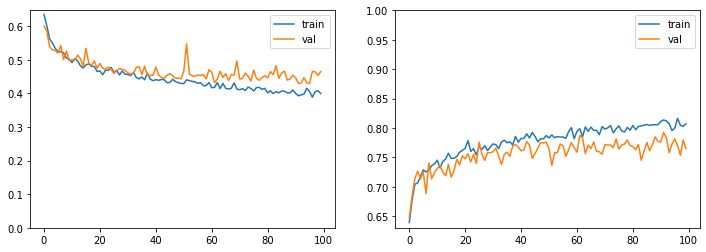

In [19]:
y = np.array([mrk.photo_reqs.flash_reflection_on_skin.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'flash_reflection_on_skin')
list_model_files.append(model_file)

#### 14. Red Eyes 

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6507 - accuracy: 0.5102 - precision: 0.8967 - recall: 0.4327 - f1: 0.5736 - specificity: 0.8043 - negative_predictive_value: 0.2720 - matthews_correlation_coefficient: 0.2000 - val_loss: 0.6604 - val_accuracy: 0.5490 - val_precision: 0.9261 - val_recall: 0.4792 - val_f1: 0.6218 - val_specificity: 0.8343 - val_negative_predictive_value: 0.2988 - val_matthews_correlation_coefficient: 0.2643

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.26426, saving model to ../models/autoencoders_requirements/red_eyes_2020_03_24-14_48_25.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6411 - accuracy: 0.5297 - precision: 0.9004 - recall: 0.4596 - f1: 0.5948 - specificity: 0.7887 - negative_predictive_value: 0.2850 - matthews_correlation_coefficient: 0.2128 - val_loss: 0.6219 - val_accuracy: 0.5663 - val_precision: 0.


Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.35424
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5706 - accuracy: 0.6777 - precision: 0.9099 - recall: 0.6638 - f1: 0.7583 - specificity: 0.7520 - negative_predictive_value: 0.3782 - matthews_correlation_coefficient: 0.3425 - val_loss: 0.5693 - val_accuracy: 0.6843 - val_precision: 0.9250 - val_recall: 0.6656 - val_f1: 0.7684 - val_specificity: 0.7603 - val_negative_predictive_value: 0.3745 - val_matthews_correlation_coefficient: 0.3558

Epoch 00016: val_matthews_correlation_coefficient improved from 0.35424 to 0.35576, saving model to ../models/autoencoders_requirements/red_eyes_2020_03_24-14_48_25.h5
Epoch 17/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5635 - accuracy: 0.6766 - precision: 0.9134 - recall: 0.6534 - f1: 0.7547 - specificity: 0.7693 - negative_predictive_value: 0.3817 - matthews_correlation_coefficient: 0.3509 - val_loss: 0.5219 - val

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5429 - accuracy: 0.6965 - precision: 0.9114 - recall: 0.6723 - f1: 0.7671 - specificity: 0.7868 - negative_predictive_value: 0.4042 - matthews_correlation_coefficient: 0.3767 - val_loss: 0.6536 - val_accuracy: 0.6167 - val_precision: 0.9380 - val_recall: 0.5646 - val_f1: 0.6966 - val_specificity: 0.8258 - val_negative_predictive_value: 0.3318 - val_matthews_correlation_coefficient: 0.3233

Epoch 00030: val_matthews_correlation_coefficient did not improve from 0.37929
Epoch 31/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5450 - accuracy: 0.6883 - precision: 0.9177 - recall: 0.6678 - f1: 0.7651 - specificity: 0.7523 - negative_predictive_value: 0.3893 - matthews_correlation_coefficient: 0.3578 - val_loss: 0.5265 - val_accuracy: 0.7042 - val_precision: 0.9098 - val_recall: 0.7066 - val_f1: 0.7915 - val_specificity: 0.7118 - val_negative_predictive_value: 0.3852 - val_matthews_correlation_coefficie


Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.39271
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5235 - accuracy: 0.7046 - precision: 0.9183 - recall: 0.6889 - f1: 0.7808 - specificity: 0.7608 - negative_predictive_value: 0.4042 - matthews_correlation_coefficient: 0.3789 - val_loss: 0.5434 - val_accuracy: 0.6912 - val_precision: 0.9294 - val_recall: 0.6722 - val_f1: 0.7745 - val_specificity: 0.7761 - val_negative_predictive_value: 0.3818 - val_matthews_correlation_coefficient: 0.3719

Epoch 00045: val_matthews_correlation_coefficient did not improve from 0.39271
Epoch 46/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5168 - accuracy: 0.7202 - precision: 0.9229 - recall: 0.7040 - f1: 0.7920 - specificity: 0.7801 - negative_predictive_value: 0.4255 - matthews_correlation_coefficient: 0.4068 - val_loss: 0.5721 - val_accuracy: 0.6782 - val_precision: 0.9319 - val_recall: 0.6525 - val_f1: 0.7604 - val_spe


Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.39271
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5154 - accuracy: 0.7234 - precision: 0.9236 - recall: 0.7148 - f1: 0.7984 - specificity: 0.7756 - negative_predictive_value: 0.4339 - matthews_correlation_coefficient: 0.4144 - val_loss: 0.6359 - val_accuracy: 0.6401 - val_precision: 0.9464 - val_recall: 0.5898 - val_f1: 0.7196 - val_specificity: 0.8361 - val_negative_predictive_value: 0.3490 - val_matthews_correlation_coefficient: 0.3533

Epoch 00060: val_matthews_correlation_coefficient did not improve from 0.39271
Epoch 61/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5010 - accuracy: 0.7241 - precision: 0.9277 - recall: 0.7081 - f1: 0.7957 - specificity: 0.7846 - negative_predictive_value: 0.4335 - matthews_correlation_coefficient: 0.4184 - val_loss: 0.5510 - val_accuracy: 0.6826 - val_precision: 0.9248 - val_recall: 0.6619 - val_f1: 0.7656 - val_spe


Epoch 00074: val_matthews_correlation_coefficient did not improve from 0.40161
Epoch 75/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4883 - accuracy: 0.7354 - precision: 0.9215 - recall: 0.7262 - f1: 0.8067 - specificity: 0.7727 - negative_predictive_value: 0.4458 - matthews_correlation_coefficient: 0.4241 - val_loss: 0.7546 - val_accuracy: 0.6114 - val_precision: 0.9420 - val_recall: 0.5555 - val_f1: 0.6912 - val_specificity: 0.8413 - val_negative_predictive_value: 0.3337 - val_matthews_correlation_coefficient: 0.3293

Epoch 00075: val_matthews_correlation_coefficient did not improve from 0.40161
Epoch 76/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5058 - accuracy: 0.7278 - precision: 0.9250 - recall: 0.7162 - f1: 0.7992 - specificity: 0.7812 - negative_predictive_value: 0.4366 - matthews_correlation_coefficient: 0.4236 - val_loss: 0.5872 - val_accuracy: 0.6557 - val_precision: 0.9397 - val_recall: 0.6157 - val_f1: 0.7374 - val_spe


Epoch 00089: val_matthews_correlation_coefficient did not improve from 0.40161
Epoch 90/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4937 - accuracy: 0.7293 - precision: 0.9159 - recall: 0.7143 - f1: 0.7958 - specificity: 0.7781 - negative_predictive_value: 0.4350 - matthews_correlation_coefficient: 0.4178 - val_loss: 0.7161 - val_accuracy: 0.5932 - val_precision: 0.9411 - val_recall: 0.5327 - val_f1: 0.6715 - val_specificity: 0.8398 - val_negative_predictive_value: 0.3218 - val_matthews_correlation_coefficient: 0.3116

Epoch 00090: val_matthews_correlation_coefficient did not improve from 0.40161
Epoch 91/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5053 - accuracy: 0.7219 - precision: 0.9272 - recall: 0.7072 - f1: 0.7923 - specificity: 0.7826 - negative_predictive_value: 0.4361 - matthews_correlation_coefficient: 0.4183 - val_loss: 0.6728 - val_accuracy: 0.6080 - val_precision: 0.9435 - val_recall: 0.5492 - val_f1: 0.6846 - val_spe

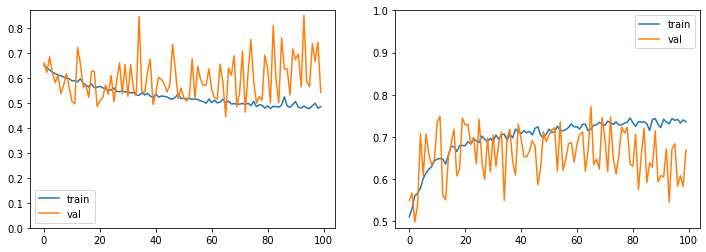

In [20]:
y = np.array([mrk.photo_reqs.red_eyes.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'red_eyes')
list_model_files.append(model_file)

#### 15. Shadows Behind Head 

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4653 - accuracy: 0.7592 - precision: 0.8739 - recall: 0.7573 - f1: 0.8044 - specificity: 0.7716 - negative_predictive_value: 0.6030 - matthews_correlation_coefficient: 0.5037 - val_loss: 0.4049 - val_accuracy: 0.7936 - val_precision: 0.8409 - val_recall: 0.8640 - val_f1: 0.8493 - val_specificity: 0.6397 - val_negative_predictive_value: 0.6767 - val_matthews_correlation_coefficient: 0.5091

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.50911, saving model to ../models/autoencoders_requirements/shadows_behind_head_2020_03_24-15_03_13.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4230 - accuracy: 0.7790 - precision: 0.9013 - recall: 0.7562 - f1: 0.8168 - specificity: 0.8255 - negative_predictive_value: 0.6273 - matthews_correlation_coefficient: 0.5549 - val_loss: 0.4686 - val_accuracy: 0.7415 - val_pr


Epoch 00014: val_matthews_correlation_coefficient improved from 0.60450 to 0.61023, saving model to ../models/autoencoders_requirements/shadows_behind_head_2020_03_24-15_03_13.h5
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3725 - accuracy: 0.8247 - precision: 0.9171 - recall: 0.8140 - f1: 0.8587 - specificity: 0.8489 - negative_predictive_value: 0.6900 - matthews_correlation_coefficient: 0.6322 - val_loss: 0.3534 - val_accuracy: 0.8265 - val_precision: 0.8687 - val_recall: 0.8778 - val_f1: 0.8705 - val_specificity: 0.7050 - val_negative_predictive_value: 0.7284 - val_matthews_correlation_coefficient: 0.5885

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.61023
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3734 - accuracy: 0.8163 - precision: 0.9168 - recall: 0.8008 - f1: 0.8499 - specificity: 0.8473 - negative_predictive_value: 0.6803 - matthews_correlation_coefficient: 0.6223 - val_loss: 0

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3366 - accuracy: 0.8471 - precision: 0.9279 - recall: 0.8416 - f1: 0.8788 - specificity: 0.8590 - negative_predictive_value: 0.7245 - matthews_correlation_coefficient: 0.6743 - val_loss: 0.3184 - val_accuracy: 0.8656 - val_precision: 0.9049 - val_recall: 0.8964 - val_f1: 0.8980 - val_specificity: 0.7910 - val_negative_predictive_value: 0.7789 - val_matthews_correlation_coefficient: 0.6837

Epoch 00028: val_matthews_correlation_coefficient improved from 0.66162 to 0.68374, saving model to ../models/autoencoders_requirements/shadows_behind_head_2020_03_24-15_03_13.h5
Epoch 29/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3358 - accuracy: 0.8451 - precision: 0.9226 - recall: 0.8397 - f1: 0.8755 - specificity: 0.8540 - negative_predictive_value: 0.7264 - matthews_correlation_coefficient: 0.6714 - val_loss: 0.3347 - val_accuracy: 0.8413 - val_precision: 0.8444 - val_recall: 0.9411 - val_f1: 0.8880 - 

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3212 - accuracy: 0.8544 - precision: 0.9150 - recall: 0.8483 - f1: 0.8773 - specificity: 0.8559 - negative_predictive_value: 0.7458 - matthews_correlation_coefficient: 0.6823 - val_loss: 0.3326 - val_accuracy: 0.8422 - val_precision: 0.9400 - val_recall: 0.8209 - val_f1: 0.8724 - val_specificity: 0.8765 - val_negative_predictive_value: 0.6961 - val_matthews_correlation_coefficient: 0.6643

Epoch 00042: val_matthews_correlation_coefficient did not improve from 0.70482
Epoch 43/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3436 - accuracy: 0.8427 - precision: 0.9184 - recall: 0.8316 - f1: 0.8675 - specificity: 0.8549 - negative_predictive_value: 0.7287 - matthews_correlation_coefficient: 0.6644 - val_loss: 0.3205 - val_accuracy: 0.8664 - val_precision: 0.9298 - val_recall: 0.8681 - val_f1: 0.8944 - val_specificity: 0.8524 - val_negative_predictive_value: 0.7561 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3239 - accuracy: 0.8584 - precision: 0.9330 - recall: 0.8519 - f1: 0.8859 - specificity: 0.8735 - negative_predictive_value: 0.7483 - matthews_correlation_coefficient: 0.7016 - val_loss: 0.3001 - val_accuracy: 0.8742 - val_precision: 0.8944 - val_recall: 0.9239 - val_f1: 0.9064 - val_specificity: 0.7613 - val_negative_predictive_value: 0.8211 - val_matthews_correlation_coefficient: 0.6985

Epoch 00056: val_matthews_correlation_coefficient did not improve from 0.71920
Epoch 57/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3015 - accuracy: 0.8705 - precision: 0.9305 - recall: 0.8727 - f1: 0.8981 - specificity: 0.8632 - negative_predictive_value: 0.7691 - matthews_correlation_coefficient: 0.7167 - val_loss: 0.2845 - val_accuracy: 0.8829 - val_precision: 0.9131 - val_recall: 0.9165 - val_f1: 0.9126 - val_specificity: 0.8049 - val_negative_predictive_value: 0.8058 - val_matthews_correlation_coefficie


Epoch 00070: val_matthews_correlation_coefficient did not improve from 0.72721
Epoch 71/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2850 - accuracy: 0.8785 - precision: 0.9361 - recall: 0.8774 - f1: 0.9024 - specificity: 0.8755 - negative_predictive_value: 0.7828 - matthews_correlation_coefficient: 0.7362 - val_loss: 0.3049 - val_accuracy: 0.8664 - val_precision: 0.9378 - val_recall: 0.8614 - val_f1: 0.8947 - val_specificity: 0.8610 - val_negative_predictive_value: 0.7431 - val_matthews_correlation_coefficient: 0.7001

Epoch 00071: val_matthews_correlation_coefficient did not improve from 0.72721
Epoch 72/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2941 - accuracy: 0.8772 - precision: 0.9337 - recall: 0.8809 - f1: 0.9042 - specificity: 0.8699 - negative_predictive_value: 0.7802 - matthews_correlation_coefficient: 0.7311 - val_loss: 0.2732 - val_accuracy: 0.8838 - val_precision: 0.9227 - val_recall: 0.9061 - val_f1: 0.9115 - val_spe


Epoch 00085: val_matthews_correlation_coefficient improved from 0.72728 to 0.73168, saving model to ../models/autoencoders_requirements/shadows_behind_head_2020_03_24-15_03_13.h5
Epoch 86/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2813 - accuracy: 0.8794 - precision: 0.9332 - recall: 0.8786 - f1: 0.9016 - specificity: 0.8767 - negative_predictive_value: 0.7824 - matthews_correlation_coefficient: 0.7359 - val_loss: 0.3025 - val_accuracy: 0.8647 - val_precision: 0.9286 - val_recall: 0.8697 - val_f1: 0.8951 - val_specificity: 0.8457 - val_negative_predictive_value: 0.7486 - val_matthews_correlation_coefficient: 0.6946

Epoch 00086: val_matthews_correlation_coefficient did not improve from 0.73168
Epoch 87/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2771 - accuracy: 0.8790 - precision: 0.9334 - recall: 0.8816 - f1: 0.9032 - specificity: 0.8729 - negative_predictive_value: 0.7851 - matthews_correlation_coefficient: 0.7369 - val_loss: 0

4610/4610 [==============================] - 9s 2ms/step - loss: 0.2640 - accuracy: 0.8863 - precision: 0.9387 - recall: 0.8865 - f1: 0.9085 - specificity: 0.8744 - negative_predictive_value: 0.8030 - matthews_correlation_coefficient: 0.7521 - val_loss: 0.2933 - val_accuracy: 0.8803 - val_precision: 0.9494 - val_recall: 0.8727 - val_f1: 0.9064 - val_specificity: 0.8812 - val_negative_predictive_value: 0.7608 - val_matthews_correlation_coefficient: 0.7302

Epoch 00100: val_matthews_correlation_coefficient did not improve from 0.74504

   Final Accuracy:  88.03%
  Final Precision:  94.61%
     Final Recall:  86.96%
  Final F-measure:  90.62%
Final Specificity:  90.16%
        Final NPV:  77.68%
        Final MCC:  74.66%
[[348  38]
 [100 667]]
              precision    recall  f1-score   support

           0       0.78      0.90      0.83       386
           1       0.95      0.87      0.91       767

    accuracy                           0.88      1153
   macro avg       0.86      0

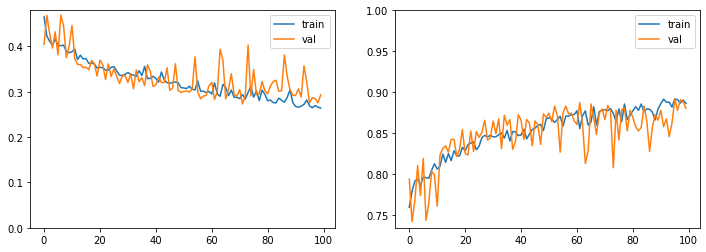

In [21]:
y = np.array([mrk.photo_reqs.shadows_behind_head.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'shadows_behind_head')
list_model_files.append(model_file)

#### 16. Shadows Across Face

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6172 - accuracy: 0.6341 - precision: 0.8684 - recall: 0.6041 - f1: 0.6994 - specificity: 0.7324 - negative_predictive_value: 0.3843 - matthews_correlation_coefficient: 0.2956 - val_loss: 0.6656 - val_accuracy: 0.6236 - val_precision: 0.8508 - val_recall: 0.5746 - val_f1: 0.6795 - val_specificity: 0.7272 - val_negative_predictive_value: 0.3612 - val_matthews_correlation_coefficient: 0.2783

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.27826, saving model to ../models/autoencoders_requirements/shadows_across_face_2020_03_24-15_17_59.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5806 - accuracy: 0.6915 - precision: 0.8937 - recall: 0.6743 - f1: 0.7617 - specificity: 0.7454 - negative_predictive_value: 0.4304 - matthews_correlation_coefficient: 0.3676 - val_loss: 0.6110 - val_accuracy: 0.6834 - val_pr

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5070 - accuracy: 0.7477 - precision: 0.9165 - recall: 0.7354 - f1: 0.8113 - specificity: 0.7874 - negative_predictive_value: 0.4941 - matthews_correlation_coefficient: 0.4611 - val_loss: 0.5144 - val_accuracy: 0.7580 - val_precision: 0.8565 - val_recall: 0.7660 - val_f1: 0.8062 - val_specificity: 0.6847 - val_negative_predictive_value: 0.5171 - val_matthews_correlation_coefficient: 0.4081

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.41171
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5081 - accuracy: 0.7518 - precision: 0.9152 - recall: 0.7402 - f1: 0.8121 - specificity: 0.7853 - negative_predictive_value: 0.5068 - matthews_correlation_coefficient: 0.4698 - val_loss: 0.5359 - val_accuracy: 0.7441 - val_precision: 0.8611 - val_recall: 0.7405 - val_f1: 0.7937 - val_specificity: 0.7037 - val_negative_predictive_value: 0.4960 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4777 - accuracy: 0.7703 - precision: 0.9277 - recall: 0.7582 - f1: 0.8280 - specificity: 0.8111 - negative_predictive_value: 0.5318 - matthews_correlation_coefficient: 0.5088 - val_loss: 0.5107 - val_accuracy: 0.7528 - val_precision: 0.8584 - val_recall: 0.7555 - val_f1: 0.8011 - val_specificity: 0.6893 - val_negative_predictive_value: 0.5092 - val_matthews_correlation_coefficient: 0.4022

Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.42116
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4755 - accuracy: 0.7718 - precision: 0.9265 - recall: 0.7597 - f1: 0.8303 - specificity: 0.8104 - negative_predictive_value: 0.5262 - matthews_correlation_coefficient: 0.5068 - val_loss: 0.4993 - val_accuracy: 0.7589 - val_precision: 0.8602 - val_recall: 0.7629 - val_f1: 0.8067 - val_specificity: 0.6897 - val_negative_predictive_value: 0.5146 - val_matthews_correlation_coefficie


Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.45364
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4619 - accuracy: 0.7711 - precision: 0.9263 - recall: 0.7631 - f1: 0.8311 - specificity: 0.8096 - negative_predictive_value: 0.5277 - matthews_correlation_coefficient: 0.5070 - val_loss: 0.4395 - val_accuracy: 0.7918 - val_precision: 0.8520 - val_recall: 0.8197 - val_f1: 0.8339 - val_specificity: 0.6396 - val_negative_predictive_value: 0.5713 - val_matthews_correlation_coefficient: 0.4387

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.45364
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4619 - accuracy: 0.7733 - precision: 0.9276 - recall: 0.7621 - f1: 0.8293 - specificity: 0.8176 - negative_predictive_value: 0.5357 - matthews_correlation_coefficient: 0.5165 - val_loss: 0.5214 - val_accuracy: 0.7546 - val_precision: 0.8861 - val_recall: 0.7303 - val_f1: 0.7987 - val_spe


Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.45364
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4497 - accuracy: 0.7844 - precision: 0.9254 - recall: 0.7817 - f1: 0.8430 - specificity: 0.7966 - negative_predictive_value: 0.5482 - matthews_correlation_coefficient: 0.5210 - val_loss: 0.4922 - val_accuracy: 0.7528 - val_precision: 0.8796 - val_recall: 0.7332 - val_f1: 0.7975 - val_specificity: 0.7520 - val_negative_predictive_value: 0.5109 - val_matthews_correlation_coefficient: 0.4334

Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.45364
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4345 - accuracy: 0.7874 - precision: 0.9362 - recall: 0.7745 - f1: 0.8436 - specificity: 0.8242 - negative_predictive_value: 0.5432 - matthews_correlation_coefficient: 0.5332 - val_loss: 0.6285 - val_accuracy: 0.6921 - val_precision: 0.9114 - val_recall: 0.6199 - val_f1: 0.7340 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4282 - accuracy: 0.7946 - precision: 0.9342 - recall: 0.7877 - f1: 0.8499 - specificity: 0.8294 - negative_predictive_value: 0.5591 - matthews_correlation_coefficient: 0.5481 - val_loss: 0.4773 - val_accuracy: 0.7736 - val_precision: 0.8640 - val_recall: 0.7817 - val_f1: 0.8177 - val_specificity: 0.6866 - val_negative_predictive_value: 0.5482 - val_matthews_correlation_coefficient: 0.4358

Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.46858
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4275 - accuracy: 0.7978 - precision: 0.9332 - recall: 0.7939 - f1: 0.8533 - specificity: 0.8195 - negative_predictive_value: 0.5662 - matthews_correlation_coefficient: 0.5509 - val_loss: 0.4688 - val_accuracy: 0.7537 - val_precision: 0.8714 - val_recall: 0.7419 - val_f1: 0.7987 - val_specificity: 0.7355 - val_negative_predictive_value: 0.5169 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4181 - accuracy: 0.7993 - precision: 0.9358 - recall: 0.7904 - f1: 0.8526 - specificity: 0.8384 - negative_predictive_value: 0.5598 - matthews_correlation_coefficient: 0.5572 - val_loss: 0.4618 - val_accuracy: 0.7806 - val_precision: 0.8666 - val_recall: 0.7852 - val_f1: 0.8221 - val_specificity: 0.7077 - val_negative_predictive_value: 0.5524 - val_matthews_correlation_coefficient: 0.4523

Epoch 00088: val_matthews_correlation_coefficient did not improve from 0.46858
Epoch 89/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4215 - accuracy: 0.7931 - precision: 0.9315 - recall: 0.7724 - f1: 0.8405 - specificity: 0.8456 - negative_predictive_value: 0.5607 - matthews_correlation_coefficient: 0.5485 - val_loss: 0.4703 - val_accuracy: 0.7754 - val_precision: 0.8887 - val_recall: 0.7563 - val_f1: 0.8148 - val_specificity: 0.7740 - val_negative_predictive_value: 0.5424 - val_matthews_correlation_coefficie

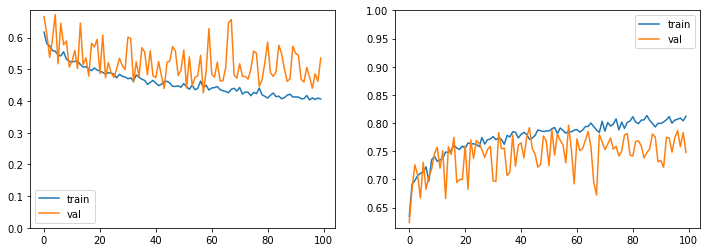

In [22]:
y = np.array([mrk.photo_reqs.shadows_across_face.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'shadows_across_face')
list_model_files.append(model_file)

#### 17. Dark Tinted Lenses

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.5776 - accuracy: 0.5362 - precision: 0.9630 - recall: 0.4917 - f1: 0.6452 - specificity: 0.8576 - negative_predictive_value: 0.1822 - matthews_correlation_coefficient: 0.2254 - val_loss: 0.7165 - val_accuracy: 0.4657 - val_precision: 0.9556 - val_recall: 0.3949 - val_f1: 0.5530 - val_specificity: 0.9316 - val_negative_predictive_value: 0.1866 - val_matthews_correlation_coefficient: 0.2134

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.21341, saving model to ../models/autoencoders_requirements/dark_tinted_lenses_2020_03_24-16_17_41.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5594 - accuracy: 0.5644 - precision: 0.9672 - recall: 0.5310 - f1: 0.6773 - specificity: 0.8021 - negative_predictive_value: 0.1880 - matthews_correlation_coefficient: 0.2286 - val_loss: 0.5532 - val_accuracy: 0.5256 - val_pr


Epoch 00014: val_matthews_correlation_coefficient improved from 0.31574 to 0.32630, saving model to ../models/autoencoders_requirements/dark_tinted_lenses_2020_03_24-16_17_41.h5
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4531 - accuracy: 0.7184 - precision: 0.9659 - recall: 0.6996 - f1: 0.8051 - specificity: 0.8323 - negative_predictive_value: 0.2765 - matthews_correlation_coefficient: 0.3575 - val_loss: 0.5992 - val_accuracy: 0.6193 - val_precision: 0.9542 - val_recall: 0.5650 - val_f1: 0.7052 - val_specificity: 0.9077 - val_negative_predictive_value: 0.2354 - val_matthews_correlation_coefficient: 0.2939

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.32630
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4412 - accuracy: 0.7230 - precision: 0.9746 - recall: 0.7101 - f1: 0.8156 - specificity: 0.8325 - negative_predictive_value: 0.2776 - matthews_correlation_coefficient: 0.3617 - val_loss: 0.


Epoch 00028: val_matthews_correlation_coefficient did not improve from 0.43355
Epoch 29/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3900 - accuracy: 0.7707 - precision: 0.9836 - recall: 0.7538 - f1: 0.8487 - specificity: 0.8725 - negative_predictive_value: 0.3243 - matthews_correlation_coefficient: 0.4319 - val_loss: 0.3865 - val_accuracy: 0.7832 - val_precision: 0.9473 - val_recall: 0.7567 - val_f1: 0.8385 - val_specificity: 0.8082 - val_negative_predictive_value: 0.3182 - val_matthews_correlation_coefficient: 0.4066

Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.43355
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4014 - accuracy: 0.7657 - precision: 0.9779 - recall: 0.7569 - f1: 0.8476 - specificity: 0.8568 - negative_predictive_value: 0.3330 - matthews_correlation_coefficient: 0.4283 - val_loss: 0.4464 - val_accuracy: 0.7398 - val_precision: 0.9582 - val_recall: 0.6975 - val_f1: 0.8049 - val_spe


Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.45898
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3917 - accuracy: 0.7740 - precision: 0.9801 - recall: 0.7617 - f1: 0.8490 - specificity: 0.8286 - negative_predictive_value: 0.3388 - matthews_correlation_coefficient: 0.4262 - val_loss: 0.4029 - val_accuracy: 0.7580 - val_precision: 0.9664 - val_recall: 0.7112 - val_f1: 0.8166 - val_specificity: 0.9358 - val_negative_predictive_value: 0.3258 - val_matthews_correlation_coefficient: 0.4271

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.45898
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3711 - accuracy: 0.7720 - precision: 0.9814 - recall: 0.7604 - f1: 0.8522 - specificity: 0.8684 - negative_predictive_value: 0.3247 - matthews_correlation_coefficient: 0.4286 - val_loss: 0.3138 - val_accuracy: 0.8404 - val_precision: 0.9490 - val_recall: 0.8183 - val_f1: 0.8779 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3805 - accuracy: 0.7692 - precision: 0.9765 - recall: 0.7496 - f1: 0.8405 - specificity: 0.8502 - negative_predictive_value: 0.3389 - matthews_correlation_coefficient: 0.4289 - val_loss: 0.6904 - val_accuracy: 0.6271 - val_precision: 0.9713 - val_recall: 0.5638 - val_f1: 0.7092 - val_specificity: 0.9691 - val_negative_predictive_value: 0.2442 - val_matthews_correlation_coefficient: 0.3333

Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.48598
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3834 - accuracy: 0.7711 - precision: 0.9807 - recall: 0.7553 - f1: 0.8455 - specificity: 0.8507 - negative_predictive_value: 0.3412 - matthews_correlation_coefficient: 0.4309 - val_loss: 0.4416 - val_accuracy: 0.7398 - val_precision: 0.9688 - val_recall: 0.6891 - val_f1: 0.8027 - val_specificity: 0.9562 - val_negative_predictive_value: 0.3081 - val_matthews_correlation_coefficie


Epoch 00072: val_matthews_correlation_coefficient did not improve from 0.48598
Epoch 73/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3363 - accuracy: 0.8087 - precision: 0.9832 - recall: 0.8005 - f1: 0.8779 - specificity: 0.8717 - negative_predictive_value: 0.3681 - matthews_correlation_coefficient: 0.4772 - val_loss: 0.5905 - val_accuracy: 0.6791 - val_precision: 0.9713 - val_recall: 0.6208 - val_f1: 0.7540 - val_specificity: 0.9691 - val_negative_predictive_value: 0.2704 - val_matthews_correlation_coefficient: 0.3714

Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.48598
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3366 - accuracy: 0.8078 - precision: 0.9824 - recall: 0.7990 - f1: 0.8760 - specificity: 0.8469 - negative_predictive_value: 0.3832 - matthews_correlation_coefficient: 0.4750 - val_loss: 0.7185 - val_accuracy: 0.6219 - val_precision: 0.9712 - val_recall: 0.5583 - val_f1: 0.7052 - val_spe

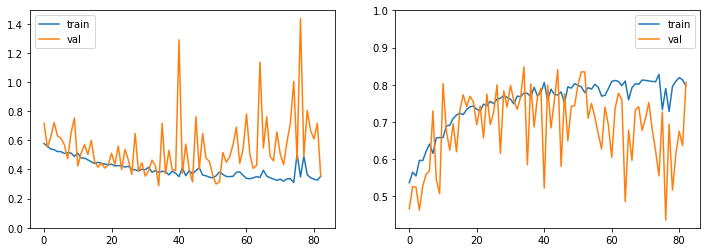

In [23]:
y = np.array([mrk.photo_reqs.dark_tinted_lenses.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'dark_tinted_lenses')
list_model_files.append(model_file)

#### 18. Flash Reflection on Lenses

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5831 - accuracy: 0.6499 - precision: 0.9086 - recall: 0.6260 - f1: 0.7321 - specificity: 0.7539 - negative_predictive_value: 0.3516 - matthews_correlation_coefficient: 0.3120 - val_loss: 0.5234 - val_accuracy: 0.7476 - val_precision: 0.8686 - val_recall: 0.8152 - val_f1: 0.8383 - val_specificity: 0.4823 - val_negative_predictive_value: 0.4009 - val_matthews_correlation_coefficient: 0.2808

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.28082, saving model to ../models/autoencoders_requirements/flash_reflection_on_lenses_2020_03_24-16_30_07.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5716 - accuracy: 0.6879 - precision: 0.8950 - recall: 0.6821 - f1: 0.7656 - specificity: 0.7012 - negative_predictive_value: 0.3715 - matthews_correlation_coefficient: 0.3226 - val_loss: 0.6765 - val_accuracy: 0.6193 -


Epoch 00014: val_matthews_correlation_coefficient improved from 0.33823 to 0.34238, saving model to ../models/autoencoders_requirements/flash_reflection_on_lenses_2020_03_24-16_30_07.h5
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5339 - accuracy: 0.7132 - precision: 0.9018 - recall: 0.7081 - f1: 0.7872 - specificity: 0.7282 - negative_predictive_value: 0.4006 - matthews_correlation_coefficient: 0.3659 - val_loss: 0.5364 - val_accuracy: 0.6999 - val_precision: 0.9153 - val_recall: 0.6956 - val_f1: 0.7851 - val_specificity: 0.7236 - val_negative_predictive_value: 0.3803 - val_matthews_correlation_coefficient: 0.3504

Epoch 00015: val_matthews_correlation_coefficient improved from 0.34238 to 0.35036, saving model to ../models/autoencoders_requirements/flash_reflection_on_lenses_2020_03_24-16_30_07.h5
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5293 - accuracy: 0.7156 - precision: 0.9153 - recall: 0.7117 - f1: 0.7957 


Epoch 00028: val_matthews_correlation_coefficient did not improve from 0.39877
Epoch 29/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5049 - accuracy: 0.7330 - precision: 0.9200 - recall: 0.7293 - f1: 0.8067 - specificity: 0.7403 - negative_predictive_value: 0.4286 - matthews_correlation_coefficient: 0.4021 - val_loss: 0.6746 - val_accuracy: 0.6297 - val_precision: 0.9456 - val_recall: 0.5789 - val_f1: 0.7102 - val_specificity: 0.8410 - val_negative_predictive_value: 0.3398 - val_matthews_correlation_coefficient: 0.3440

Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.39877
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5116 - accuracy: 0.7174 - precision: 0.9194 - recall: 0.7089 - f1: 0.7923 - specificity: 0.7469 - negative_predictive_value: 0.4121 - matthews_correlation_coefficient: 0.3861 - val_loss: 0.5444 - val_accuracy: 0.7034 - val_precision: 0.9448 - val_recall: 0.6748 - val_f1: 0.7816 - val_spe


Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.40672
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4778 - accuracy: 0.7497 - precision: 0.9193 - recall: 0.7421 - f1: 0.8172 - specificity: 0.7625 - negative_predictive_value: 0.4440 - matthews_correlation_coefficient: 0.4319 - val_loss: 0.6174 - val_accuracy: 0.6366 - val_precision: 0.9604 - val_recall: 0.5765 - val_f1: 0.7125 - val_specificity: 0.8858 - val_negative_predictive_value: 0.3477 - val_matthews_correlation_coefficient: 0.3752

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.40672
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4838 - accuracy: 0.7443 - precision: 0.9283 - recall: 0.7365 - f1: 0.8158 - specificity: 0.7697 - negative_predictive_value: 0.4438 - matthews_correlation_coefficient: 0.4312 - val_loss: 0.6065 - val_accuracy: 0.6661 - val_precision: 0.9494 - val_recall: 0.6236 - val_f1: 0.7459 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4883 - accuracy: 0.7284 - precision: 0.9294 - recall: 0.7134 - f1: 0.8002 - specificity: 0.7788 - negative_predictive_value: 0.4262 - matthews_correlation_coefficient: 0.4162 - val_loss: 0.5226 - val_accuracy: 0.6904 - val_precision: 0.9449 - val_recall: 0.6586 - val_f1: 0.7699 - val_specificity: 0.8269 - val_negative_predictive_value: 0.3878 - val_matthews_correlation_coefficient: 0.3995

Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.43621
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4668 - accuracy: 0.7497 - precision: 0.9270 - recall: 0.7473 - f1: 0.8205 - specificity: 0.7696 - negative_predictive_value: 0.4600 - matthews_correlation_coefficient: 0.4423 - val_loss: 0.5404 - val_accuracy: 0.6756 - val_precision: 0.9394 - val_recall: 0.6412 - val_f1: 0.7550 - val_specificity: 0.8204 - val_negative_predictive_value: 0.3725 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4598 - accuracy: 0.7588 - precision: 0.9280 - recall: 0.7543 - f1: 0.8250 - specificity: 0.7673 - negative_predictive_value: 0.4665 - matthews_correlation_coefficient: 0.4500 - val_loss: 0.6335 - val_accuracy: 0.6227 - val_precision: 0.9471 - val_recall: 0.5684 - val_f1: 0.7023 - val_specificity: 0.8516 - val_negative_predictive_value: 0.3368 - val_matthews_correlation_coefficient: 0.3433

Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.46374
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4563 - accuracy: 0.7631 - precision: 0.9336 - recall: 0.7557 - f1: 0.8292 - specificity: 0.7828 - negative_predictive_value: 0.4663 - matthews_correlation_coefficient: 0.4613 - val_loss: 0.6775 - val_accuracy: 0.6097 - val_precision: 0.9563 - val_recall: 0.5431 - val_f1: 0.6845 - val_specificity: 0.8819 - val_negative_predictive_value: 0.3283 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4728 - accuracy: 0.7451 - precision: 0.9336 - recall: 0.7374 - f1: 0.8153 - specificity: 0.7882 - negative_predictive_value: 0.4571 - matthews_correlation_coefficient: 0.4486 - val_loss: 0.6045 - val_accuracy: 0.6609 - val_precision: 0.9432 - val_recall: 0.6205 - val_f1: 0.7419 - val_specificity: 0.8368 - val_negative_predictive_value: 0.3598 - val_matthews_correlation_coefficient: 0.3703

Epoch 00088: val_matthews_correlation_coefficient did not improve from 0.46374
Epoch 89/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4470 - accuracy: 0.7751 - precision: 0.9340 - recall: 0.7714 - f1: 0.8398 - specificity: 0.7871 - negative_predictive_value: 0.4813 - matthews_correlation_coefficient: 0.4776 - val_loss: 0.5507 - val_accuracy: 0.6860 - val_precision: 0.9475 - val_recall: 0.6507 - val_f1: 0.7661 - val_specificity: 0.8358 - val_negative_predictive_value: 0.3785 - val_matthews_correlation_coefficie

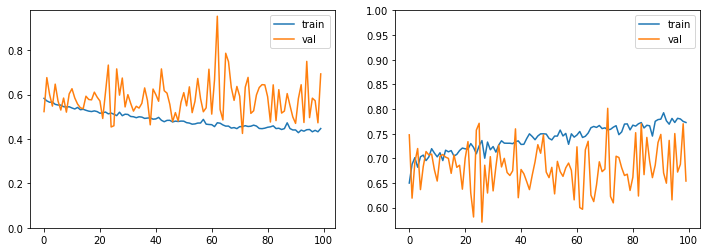

In [24]:
y = np.array([mrk.photo_reqs.flash_reflection_on_lenses.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'flash_reflection_on_lenses')
list_model_files.append(model_file)

#### 19. Frames Too Heavy

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.5911 - accuracy: 0.7879 - precision: 0.9987 - recall: 0.7900 - f1: 0.8731 - specificity: 0.0621 - negative_predictive_value: 0.0067 - matthews_correlation_coefficient: 0.0169 - val_loss: 0.1556 - val_accuracy: 0.9670 - val_precision: 0.9983 - val_recall: 0.9695 - val_f1: 0.9833 - val_specificity: 0.0541 - val_negative_predictive_value: 0.0270 - val_matthews_correlation_coefficient: 0.0367

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.03673, saving model to ../models/autoencoders_requirements/frames_too_heavy_2020_03_24-16_44_52.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4883 - accuracy: 0.7336 - precision: 0.9989 - recall: 0.7358 - f1: 0.8349 - specificity: 0.0690 - negative_predictive_value: 0.0091 - matthews_correlation_coefficient: 0.0201 - val_loss: 0.1757 - val_accuracy: 0.9332 - val_prec

4610/4610 [==============================] - 9s 2ms/step - loss: 0.1847 - accuracy: 0.8866 - precision: 1.0000 - recall: 0.8870 - f1: 0.9386 - specificity: 0.0897 - negative_predictive_value: 0.0359 - matthews_correlation_coefficient: 0.0514 - val_loss: 0.2155 - val_accuracy: 0.9020 - val_precision: 1.0000 - val_recall: 0.9043 - val_f1: 0.9488 - val_specificity: 0.1081 - val_negative_predictive_value: 0.0414 - val_matthews_correlation_coefficient: 0.0640

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.07972
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1413 - accuracy: 0.9187 - precision: 1.0000 - recall: 0.9189 - f1: 0.9569 - specificity: 0.1034 - negative_predictive_value: 0.0365 - matthews_correlation_coefficient: 0.0571 - val_loss: 0.1910 - val_accuracy: 0.9228 - val_precision: 1.0000 - val_recall: 0.9247 - val_f1: 0.9602 - val_specificity: 0.1081 - val_negative_predictive_value: 0.0473 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.1441 - accuracy: 0.9245 - precision: 0.9998 - recall: 0.9250 - f1: 0.9600 - specificity: 0.0966 - negative_predictive_value: 0.0467 - matthews_correlation_coefficient: 0.0625 - val_loss: 0.3337 - val_accuracy: 0.8699 - val_precision: 1.0000 - val_recall: 0.8730 - val_f1: 0.9310 - val_specificity: 0.1081 - val_negative_predictive_value: 0.0302 - val_matthews_correlation_coefficient: 0.0530

Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.09617
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1724 - accuracy: 0.8974 - precision: 1.0000 - recall: 0.8978 - f1: 0.9447 - specificity: 0.0966 - negative_predictive_value: 0.0319 - matthews_correlation_coefficient: 0.0527 - val_loss: 0.2011 - val_accuracy: 0.9141 - val_precision: 1.0000 - val_recall: 0.9162 - val_f1: 0.9554 - val_specificity: 0.1081 - val_negative_predictive_value: 0.0428 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.1390 - accuracy: 0.9171 - precision: 1.0000 - recall: 0.9175 - f1: 0.9554 - specificity: 0.0966 - negative_predictive_value: 0.0441 - matthews_correlation_coefficient: 0.0603 - val_loss: 0.0266 - val_accuracy: 0.9870 - val_precision: 1.0000 - val_recall: 0.9873 - val_f1: 0.9935 - val_specificity: 0.1081 - val_negative_predictive_value: 0.0946 - val_matthews_correlation_coefficient: 0.0999

Epoch 00044: val_matthews_correlation_coefficient improved from 0.09617 to 0.09988, saving model to ../models/autoencoders_requirements/frames_too_heavy_2020_03_24-16_44_52.h5
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1310 - accuracy: 0.9295 - precision: 1.0000 - recall: 0.9298 - f1: 0.9625 - specificity: 0.1034 - negative_predictive_value: 0.0601 - matthews_correlation_coefficient: 0.0731 - val_loss: 0.1169 - val_accuracy: 0.9592 - val_precision: 1.0000 - val_recall: 0.9602 - val_f1: 0.9793 - val


Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.09988
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.0765 - accuracy: 0.9523 - precision: 1.0000 - recall: 0.9525 - f1: 0.9752 - specificity: 0.1034 - negative_predictive_value: 0.0724 - matthews_correlation_coefficient: 0.0836 - val_loss: 0.1196 - val_accuracy: 0.9540 - val_precision: 1.0000 - val_recall: 0.9551 - val_f1: 0.9766 - val_specificity: 0.1081 - val_negative_predictive_value: 0.0631 - val_matthews_correlation_coefficient: 0.0797

Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.09988
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2187 - accuracy: 0.9547 - precision: 0.9996 - recall: 0.9553 - f1: 0.9764 - specificity: 0.0897 - negative_predictive_value: 0.0523 - matthews_correlation_coefficient: 0.0652 - val_loss: 0.3661 - val_accuracy: 0.8742 - val_precision: 1.0000 - val_recall: 0.8773 - val_f1: 0.9331 - val_spe


Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.09988
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.0478 - accuracy: 0.9703 - precision: 1.0000 - recall: 0.9703 - f1: 0.9846 - specificity: 0.0966 - negative_predictive_value: 0.0563 - matthews_correlation_coefficient: 0.0699 - val_loss: 0.0274 - val_accuracy: 0.9922 - val_precision: 1.0000 - val_recall: 0.9924 - val_f1: 0.9961 - val_specificity: 0.1081 - val_negative_predictive_value: 0.0946 - val_matthews_correlation_coefficient: 0.0999
Restoring model weights from the end of the best epoch

Epoch 00074: val_matthews_correlation_coefficient did not improve from 0.09988
Epoch 00074: early stopping

   Final Accuracy:  98.70%
  Final Precision: 100.00%
     Final Recall:  98.69%
  Final F-measure:  99.34%
Final Specificity: 100.00%
        Final NPV:  21.05%
        Final MCC:  45.58%
[[   4    0]
 [  15 1134]]
              precision    recall  f1-score   support

           0 

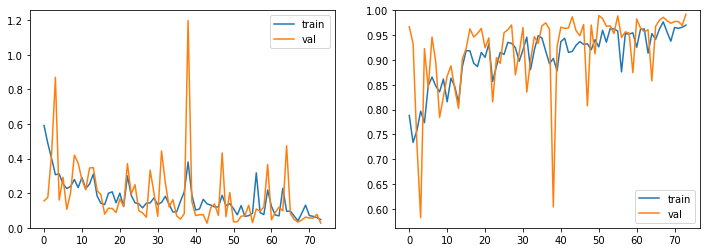

In [25]:
y = np.array([mrk.photo_reqs.frames_too_heavy.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'frames_too_heavy')
list_model_files.append(model_file)

#### 20. Frame Covering Eyes  

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.6018 - accuracy: 0.5822 - precision: 0.9240 - recall: 0.5240 - f1: 0.6548 - specificity: 0.8115 - negative_predictive_value: 0.3092 - matthews_correlation_coefficient: 0.2782 - val_loss: 0.6540 - val_accuracy: 0.5048 - val_precision: 0.9432 - val_recall: 0.4177 - val_f1: 0.5669 - val_specificity: 0.8745 - val_negative_predictive_value: 0.2791 - val_matthews_correlation_coefficient: 0.2531

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.25314, saving model to ../models/autoencoders_requirements/frame_covering_eyes_2020_03_24-16_55_56.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5780 - accuracy: 0.5985 - precision: 0.9291 - recall: 0.5382 - f1: 0.6721 - specificity: 0.8251 - negative_predictive_value: 0.3230 - matthews_correlation_coefficient: 0.3019 - val_loss: 0.6042 - val_accuracy: 0.6418 - val_p

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5496 - accuracy: 0.6438 - precision: 0.9380 - recall: 0.5923 - f1: 0.7199 - specificity: 0.8421 - negative_predictive_value: 0.3539 - matthews_correlation_coefficient: 0.3553 - val_loss: 0.5675 - val_accuracy: 0.6618 - val_precision: 0.9259 - val_recall: 0.6351 - val_f1: 0.7484 - val_specificity: 0.7913 - val_negative_predictive_value: 0.3594 - val_matthews_correlation_coefficient: 0.3472

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.37718
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5415 - accuracy: 0.6590 - precision: 0.9332 - recall: 0.6168 - f1: 0.7360 - specificity: 0.8283 - negative_predictive_value: 0.3642 - matthews_correlation_coefficient: 0.3620 - val_loss: 0.5696 - val_accuracy: 0.6635 - val_precision: 0.9232 - val_recall: 0.6406 - val_f1: 0.7513 - val_specificity: 0.7783 - val_negative_predictive_value: 0.3574 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5407 - accuracy: 0.6540 - precision: 0.9400 - recall: 0.6034 - f1: 0.7255 - specificity: 0.8392 - negative_predictive_value: 0.3634 - matthews_correlation_coefficient: 0.3658 - val_loss: 0.4569 - val_accuracy: 0.7346 - val_precision: 0.8922 - val_recall: 0.7675 - val_f1: 0.8225 - val_specificity: 0.6330 - val_negative_predictive_value: 0.4073 - val_matthews_correlation_coefficient: 0.3441

Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.41190
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5104 - accuracy: 0.6892 - precision: 0.9353 - recall: 0.6452 - f1: 0.7589 - specificity: 0.8387 - negative_predictive_value: 0.3909 - matthews_correlation_coefficient: 0.3954 - val_loss: 0.5029 - val_accuracy: 0.7147 - val_precision: 0.9450 - val_recall: 0.6912 - val_f1: 0.7941 - val_specificity: 0.8196 - val_negative_predictive_value: 0.4060 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4861 - accuracy: 0.7108 - precision: 0.9473 - recall: 0.6759 - f1: 0.7836 - specificity: 0.8455 - negative_predictive_value: 0.4132 - matthews_correlation_coefficient: 0.4317 - val_loss: 0.5095 - val_accuracy: 0.6886 - val_precision: 0.9183 - val_recall: 0.6777 - val_f1: 0.7755 - val_specificity: 0.7588 - val_negative_predictive_value: 0.3784 - val_matthews_correlation_coefficient: 0.3579

Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.42990
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4877 - accuracy: 0.7078 - precision: 0.9464 - recall: 0.6731 - f1: 0.7809 - specificity: 0.8502 - negative_predictive_value: 0.4164 - matthews_correlation_coefficient: 0.4332 - val_loss: 0.4747 - val_accuracy: 0.7095 - val_precision: 0.9155 - val_recall: 0.7100 - val_f1: 0.7952 - val_specificity: 0.7443 - val_negative_predictive_value: 0.3964 - val_matthews_correlation_coefficie


Epoch 00057: val_matthews_correlation_coefficient did not improve from 0.43553
Epoch 58/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4847 - accuracy: 0.7111 - precision: 0.9441 - recall: 0.6660 - f1: 0.7761 - specificity: 0.8708 - negative_predictive_value: 0.4134 - matthews_correlation_coefficient: 0.4413 - val_loss: 0.5253 - val_accuracy: 0.6860 - val_precision: 0.9656 - val_recall: 0.6380 - val_f1: 0.7633 - val_specificity: 0.8917 - val_negative_predictive_value: 0.3893 - val_matthews_correlation_coefficient: 0.4314

Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.43553
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4720 - accuracy: 0.7154 - precision: 0.9539 - recall: 0.6770 - f1: 0.7867 - specificity: 0.8787 - negative_predictive_value: 0.4229 - matthews_correlation_coefficient: 0.4537 - val_loss: 0.4930 - val_accuracy: 0.7008 - val_precision: 0.9545 - val_recall: 0.6654 - val_f1: 0.7796 - val_spe


Epoch 00072: val_matthews_correlation_coefficient did not improve from 0.43842
Epoch 73/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4546 - accuracy: 0.7269 - precision: 0.9539 - recall: 0.6889 - f1: 0.7954 - specificity: 0.8648 - negative_predictive_value: 0.4249 - matthews_correlation_coefficient: 0.4557 - val_loss: 0.4940 - val_accuracy: 0.7147 - val_precision: 0.9595 - val_recall: 0.6791 - val_f1: 0.7913 - val_specificity: 0.8688 - val_negative_predictive_value: 0.4094 - val_matthews_correlation_coefficient: 0.4474

Epoch 00073: val_matthews_correlation_coefficient improved from 0.43842 to 0.44739, saving model to ../models/autoencoders_requirements/frame_covering_eyes_2020_03_24-16_55_56.h5
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4669 - accuracy: 0.7269 - precision: 0.9497 - recall: 0.6911 - f1: 0.7950 - specificity: 0.8607 - negative_predictive_value: 0.4275 - matthews_correlation_coefficient: 0.4543 - val_loss: 0

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4537 - accuracy: 0.7245 - precision: 0.9541 - recall: 0.6871 - f1: 0.7937 - specificity: 0.8642 - negative_predictive_value: 0.4198 - matthews_correlation_coefficient: 0.4503 - val_loss: 0.4537 - val_accuracy: 0.7389 - val_precision: 0.9409 - val_recall: 0.7270 - val_f1: 0.8166 - val_specificity: 0.7961 - val_negative_predictive_value: 0.4249 - val_matthews_correlation_coefficient: 0.4351

Epoch 00087: val_matthews_correlation_coefficient did not improve from 0.45733
Epoch 88/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4532 - accuracy: 0.7243 - precision: 0.9528 - recall: 0.6889 - f1: 0.7957 - specificity: 0.8659 - negative_predictive_value: 0.4185 - matthews_correlation_coefficient: 0.4499 - val_loss: 0.5938 - val_accuracy: 0.6470 - val_precision: 0.9776 - val_recall: 0.5798 - val_f1: 0.7219 - val_specificity: 0.9249 - val_negative_predictive_value: 0.3607 - val_matthews_correlation_coefficie

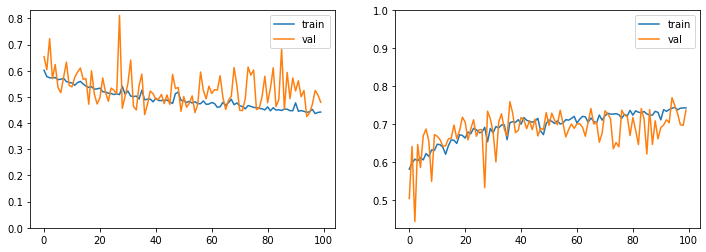

In [26]:
y = np.array([mrk.photo_reqs.frame_covering_eyes.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'frame_covering_eyes')
list_model_files.append(model_file)

#### 21. Hat/cap 

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.5944 - accuracy: 0.6117 - precision: 0.9377 - recall: 0.5893 - f1: 0.7101 - specificity: 0.7366 - negative_predictive_value: 0.2435 - matthews_correlation_coefficient: 0.2409 - val_loss: 0.4762 - val_accuracy: 0.7095 - val_precision: 0.8834 - val_recall: 0.7149 - val_f1: 0.7870 - val_specificity: 0.5334 - val_negative_predictive_value: 0.2611 - val_matthews_correlation_coefficient: 0.2146

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.21457, saving model to ../models/autoencoders_requirements/hat_cap_2020_03_24-17_10_46.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5525 - accuracy: 0.6425 - precision: 0.9509 - recall: 0.6195 - f1: 0.7384 - specificity: 0.7801 - negative_predictive_value: 0.2725 - matthews_correlation_coefficient: 0.2981 - val_loss: 0.4318 - val_accuracy: 0.7936 - val_precision: 0.


Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.35044
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5083 - accuracy: 0.7004 - precision: 0.9532 - recall: 0.6855 - f1: 0.7806 - specificity: 0.7942 - negative_predictive_value: 0.3156 - matthews_correlation_coefficient: 0.3540 - val_loss: 0.4828 - val_accuracy: 0.7207 - val_precision: 0.9304 - val_recall: 0.6877 - val_f1: 0.7883 - val_specificity: 0.7904 - val_negative_predictive_value: 0.3088 - val_matthews_correlation_coefficient: 0.3585

Epoch 00015: val_matthews_correlation_coefficient improved from 0.35044 to 0.35846, saving model to ../models/autoencoders_requirements/hat_cap_2020_03_24-17_10_46.h5
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4706 - accuracy: 0.7193 - precision: 0.9554 - recall: 0.7072 - f1: 0.8072 - specificity: 0.8029 - negative_predictive_value: 0.3235 - matthews_correlation_coefficient: 0.3768 - val_loss: 0.4029 - val_

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4348 - accuracy: 0.7460 - precision: 0.9625 - recall: 0.7327 - f1: 0.8255 - specificity: 0.8127 - negative_predictive_value: 0.3571 - matthews_correlation_coefficient: 0.4120 - val_loss: 0.3722 - val_accuracy: 0.7875 - val_precision: 0.9233 - val_recall: 0.8275 - val_f1: 0.8710 - val_specificity: 0.5382 - val_negative_predictive_value: 0.3369 - val_matthews_correlation_coefficient: 0.3029

Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.40978
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4352 - accuracy: 0.7501 - precision: 0.9630 - recall: 0.7371 - f1: 0.8299 - specificity: 0.8255 - negative_predictive_value: 0.3571 - matthews_correlation_coefficient: 0.4186 - val_loss: 0.3947 - val_accuracy: 0.7771 - val_precision: 0.9485 - val_recall: 0.7883 - val_f1: 0.8592 - val_specificity: 0.7129 - val_negative_predictive_value: 0.3490 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4157 - accuracy: 0.7605 - precision: 0.9625 - recall: 0.7524 - f1: 0.8374 - specificity: 0.8030 - negative_predictive_value: 0.3687 - matthews_correlation_coefficient: 0.4217 - val_loss: 0.3494 - val_accuracy: 0.8057 - val_precision: 0.9063 - val_recall: 0.8673 - val_f1: 0.8852 - val_specificity: 0.4301 - val_negative_predictive_value: 0.3460 - val_matthews_correlation_coefficient: 0.2710

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.40978
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4037 - accuracy: 0.7662 - precision: 0.9701 - recall: 0.7549 - f1: 0.8419 - specificity: 0.8503 - negative_predictive_value: 0.3837 - matthews_correlation_coefficient: 0.4548 - val_loss: 0.3176 - val_accuracy: 0.8317 - val_precision: 0.9261 - val_recall: 0.8790 - val_f1: 0.9005 - val_specificity: 0.5427 - val_negative_predictive_value: 0.4302 - val_matthews_correlation_coefficie


Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.45945
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4056 - accuracy: 0.7594 - precision: 0.9634 - recall: 0.7506 - f1: 0.8391 - specificity: 0.8240 - negative_predictive_value: 0.3638 - matthews_correlation_coefficient: 0.4252 - val_loss: 0.3238 - val_accuracy: 0.8317 - val_precision: 0.9169 - val_recall: 0.8888 - val_f1: 0.9015 - val_specificity: 0.4867 - val_negative_predictive_value: 0.4230 - val_matthews_correlation_coefficient: 0.3502

Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.45945
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3818 - accuracy: 0.7861 - precision: 0.9702 - recall: 0.7773 - f1: 0.8591 - specificity: 0.8492 - negative_predictive_value: 0.3921 - matthews_correlation_coefficient: 0.4685 - val_loss: 0.3290 - val_accuracy: 0.8222 - val_precision: 0.9441 - val_recall: 0.8482 - val_f1: 0.8917 - val_spe


Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.45945
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4743 - accuracy: 0.7505 - precision: 0.9438 - recall: 0.7486 - f1: 0.8226 - specificity: 0.7464 - negative_predictive_value: 0.3647 - matthews_correlation_coefficient: 0.3847 - val_loss: 0.3367 - val_accuracy: 0.8768 - val_precision: 0.9205 - val_recall: 0.9405 - val_f1: 0.9296 - val_specificity: 0.4885 - val_negative_predictive_value: 0.5706 - val_matthews_correlation_coefficient: 0.4533

Epoch 00074: val_matthews_correlation_coefficient did not improve from 0.45945
Epoch 75/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4189 - accuracy: 0.7911 - precision: 0.9546 - recall: 0.7938 - f1: 0.8611 - specificity: 0.7978 - negative_predictive_value: 0.4054 - matthews_correlation_coefficient: 0.4532 - val_loss: 0.3615 - val_accuracy: 0.8343 - val_precision: 0.9329 - val_recall: 0.8734 - val_f1: 0.9010 - val_spe

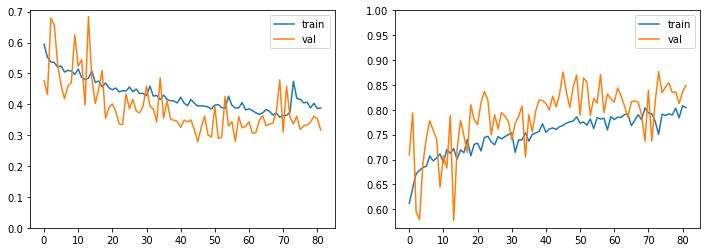

In [27]:
y = np.array([mrk.photo_reqs.hat_cap.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'hat_cap')
list_model_files.append(model_file)

#### *22. Veil Over Face*

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.4151 - accuracy: 0.7818 - precision: 0.9921 - recall: 0.7720 - f1: 0.8622 - specificity: 0.8027 - negative_predictive_value: 0.2278 - matthews_correlation_coefficient: 0.3544 - val_loss: 0.3807 - val_accuracy: 0.8387 - val_precision: 0.9643 - val_recall: 0.8136 - val_f1: 0.8811 - val_specificity: 0.7748 - val_negative_predictive_value: 0.2588 - val_matthews_correlation_coefficient: 0.3829

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.38286, saving model to ../models/autoencoders_requirements/veil_over_face_2020_03_24-17_23_02.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3224 - accuracy: 0.8698 - precision: 0.9917 - recall: 0.8666 - f1: 0.9230 - specificity: 0.7196 - negative_predictive_value: 0.3117 - matthews_correlation_coefficient: 0.4179 - val_loss: 0.4039 - val_accuracy: 0.8491 - val_precis


Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.55115
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2419 - accuracy: 0.9158 - precision: 0.9932 - recall: 0.9173 - f1: 0.9524 - specificity: 0.8023 - negative_predictive_value: 0.4604 - matthews_correlation_coefficient: 0.5620 - val_loss: 0.1886 - val_accuracy: 0.9376 - val_precision: 0.9635 - val_recall: 0.9180 - val_f1: 0.9398 - val_specificity: 0.7477 - val_negative_predictive_value: 0.4450 - val_matthews_correlation_coefficient: 0.5381

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.55115
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2488 - accuracy: 0.9197 - precision: 0.9918 - recall: 0.9224 - f1: 0.9549 - specificity: 0.7823 - negative_predictive_value: 0.4400 - matthews_correlation_coefficient: 0.5401 - val_loss: 0.2038 - val_accuracy: 0.9384 - val_precision: 0.9635 - val_recall: 0.9189 - val_f1: 0.9402 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.2005 - accuracy: 0.9386 - precision: 0.9939 - recall: 0.9377 - f1: 0.9638 - specificity: 0.7611 - negative_predictive_value: 0.5021 - matthews_correlation_coefficient: 0.5830 - val_loss: 0.1303 - val_accuracy: 0.9636 - val_precision: 0.9908 - val_recall: 0.9710 - val_f1: 0.9805 - val_specificity: 0.7658 - val_negative_predictive_value: 0.5948 - val_matthews_correlation_coefficient: 0.6447

Epoch 00029: val_matthews_correlation_coefficient improved from 0.59848 to 0.64469, saving model to ../models/autoencoders_requirements/veil_over_face_2020_03_24-17_23_02.h5
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2301 - accuracy: 0.9278 - precision: 0.9891 - recall: 0.9306 - f1: 0.9568 - specificity: 0.7816 - negative_predictive_value: 0.4989 - matthews_correlation_coefficient: 0.5805 - val_loss: 0.3644 - val_accuracy: 0.8942 - val_precision: 0.9669 - val_recall: 0.8696 - val_f1: 0.9149 - val_s


Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.64469
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1708 - accuracy: 0.9466 - precision: 0.9945 - recall: 0.9489 - f1: 0.9703 - specificity: 0.7920 - negative_predictive_value: 0.5575 - matthews_correlation_coefficient: 0.6270 - val_loss: 0.1463 - val_accuracy: 0.9532 - val_precision: 0.9654 - val_recall: 0.9324 - val_f1: 0.9482 - val_specificity: 0.7739 - val_negative_predictive_value: 0.5569 - val_matthews_correlation_coefficient: 0.6228

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.64469
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1610 - accuracy: 0.9529 - precision: 0.9942 - recall: 0.9557 - f1: 0.9740 - specificity: 0.8156 - negative_predictive_value: 0.5972 - matthews_correlation_coefficient: 0.6631 - val_loss: 0.2772 - val_accuracy: 0.9046 - val_precision: 0.9691 - val_recall: 0.8785 - val_f1: 0.9209 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.1419 - accuracy: 0.9549 - precision: 0.9958 - recall: 0.9567 - f1: 0.9751 - specificity: 0.8021 - negative_predictive_value: 0.6097 - matthews_correlation_coefficient: 0.6671 - val_loss: 0.2775 - val_accuracy: 0.9011 - val_precision: 0.9691 - val_recall: 0.8748 - val_f1: 0.9189 - val_specificity: 0.8266 - val_negative_predictive_value: 0.3625 - val_matthews_correlation_coefficient: 0.5014

Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.71410
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1575 - accuracy: 0.9499 - precision: 0.9958 - recall: 0.9509 - f1: 0.9718 - specificity: 0.8547 - negative_predictive_value: 0.6059 - matthews_correlation_coefficient: 0.6852 - val_loss: 0.4247 - val_accuracy: 0.8656 - val_precision: 0.9688 - val_recall: 0.8383 - val_f1: 0.8980 - val_specificity: 0.8266 - val_negative_predictive_value: 0.2959 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.1299 - accuracy: 0.9594 - precision: 0.9960 - recall: 0.9612 - f1: 0.9779 - specificity: 0.8352 - negative_predictive_value: 0.5976 - matthews_correlation_coefficient: 0.6762 - val_loss: 0.2461 - val_accuracy: 0.8812 - val_precision: 0.9698 - val_recall: 0.8528 - val_f1: 0.9069 - val_specificity: 0.8333 - val_negative_predictive_value: 0.3251 - val_matthews_correlation_coefficient: 0.4722

Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.71410
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1260 - accuracy: 0.9542 - precision: 0.9964 - recall: 0.9549 - f1: 0.9744 - specificity: 0.8403 - negative_predictive_value: 0.6055 - matthews_correlation_coefficient: 0.6795 - val_loss: 0.1530 - val_accuracy: 0.9324 - val_precision: 0.9959 - val_recall: 0.9326 - val_f1: 0.9629 - val_specificity: 0.8279 - val_negative_predictive_value: 0.4432 - val_matthews_correlation_coefficie


Epoch 00087: val_matthews_correlation_coefficient did not improve from 0.71410
Epoch 00087: early stopping

   Final Accuracy:  97.40%
  Final Precision:  99.34%
     Final Recall:  97.87%
  Final F-measure:  98.60%
Final Specificity:  90.41%
        Final NPV:  74.16%
        Final MCC:  80.55%
[[  66    7]
 [  23 1057]]
              precision    recall  f1-score   support

           0       0.74      0.90      0.81        73
           1       0.99      0.98      0.99      1080

    accuracy                           0.97      1153
   macro avg       0.87      0.94      0.90      1153
weighted avg       0.98      0.97      0.98      1153



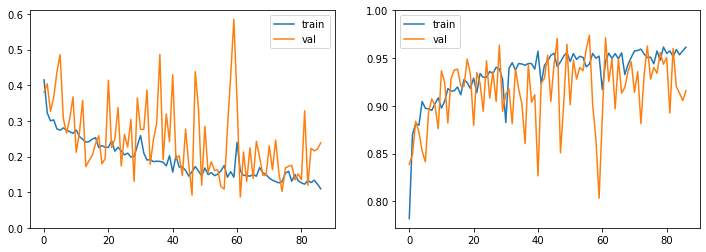

In [28]:
y = np.array([mrk.photo_reqs.veil_over_face.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'veil_over_face')
list_model_files.append(model_file)

#### 23. Mouth Open 

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.6121 - accuracy: 0.6505 - precision: 0.8765 - recall: 0.6199 - f1: 0.7152 - specificity: 0.7499 - negative_predictive_value: 0.4193 - matthews_correlation_coefficient: 0.3305 - val_loss: 0.6353 - val_accuracy: 0.6175 - val_precision: 0.8598 - val_recall: 0.5356 - val_f1: 0.6556 - val_specificity: 0.7906 - val_negative_predictive_value: 0.4064 - val_matthews_correlation_coefficient: 0.2933

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.29332, saving model to ../models/autoencoders_requirements/mouth_open_2020_03_24-17_35_57.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5897 - accuracy: 0.6653 - precision: 0.8853 - recall: 0.6325 - f1: 0.7291 - specificity: 0.7733 - negative_predictive_value: 0.4406 - matthews_correlation_coefficient: 0.3615 - val_loss: 0.6226 - val_accuracy: 0.6262 - val_precision:

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5473 - accuracy: 0.6931 - precision: 0.9017 - recall: 0.6562 - f1: 0.7539 - specificity: 0.7962 - negative_predictive_value: 0.4617 - matthews_correlation_coefficient: 0.4032 - val_loss: 0.5546 - val_accuracy: 0.6912 - val_precision: 0.8603 - val_recall: 0.6515 - val_f1: 0.7373 - val_specificity: 0.7521 - val_negative_predictive_value: 0.4654 - val_matthews_correlation_coefficient: 0.3611

Epoch 00015: val_matthews_correlation_coefficient improved from 0.34681 to 0.36106, saving model to ../models/autoencoders_requirements/mouth_open_2020_03_24-17_35_57.h5
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5410 - accuracy: 0.6985 - precision: 0.8994 - recall: 0.6650 - f1: 0.7591 - specificity: 0.7922 - negative_predictive_value: 0.4629 - matthews_correlation_coefficient: 0.4063 - val_loss: 0.5902 - val_accuracy: 0.6696 - val_precision: 0.8378 - val_recall: 0.6377 - val_f1: 0.7208 - val_speci


Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.36316
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5293 - accuracy: 0.7106 - precision: 0.8975 - recall: 0.6760 - f1: 0.7658 - specificity: 0.7998 - negative_predictive_value: 0.4775 - matthews_correlation_coefficient: 0.4271 - val_loss: 0.5787 - val_accuracy: 0.6722 - val_precision: 0.8631 - val_recall: 0.6172 - val_f1: 0.7162 - val_specificity: 0.7673 - val_negative_predictive_value: 0.4448 - val_matthews_correlation_coefficient: 0.3427

Epoch 00030: val_matthews_correlation_coefficient did not improve from 0.36316
Epoch 31/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5294 - accuracy: 0.7078 - precision: 0.9052 - recall: 0.6748 - f1: 0.7683 - specificity: 0.8077 - negative_predictive_value: 0.4767 - matthews_correlation_coefficient: 0.4275 - val_loss: 0.5552 - val_accuracy: 0.6982 - val_precision: 0.8606 - val_recall: 0.6615 - val_f1: 0.7437 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5318 - accuracy: 0.6991 - precision: 0.8941 - recall: 0.6581 - f1: 0.7521 - specificity: 0.7964 - negative_predictive_value: 0.4699 - matthews_correlation_coefficient: 0.4066 - val_loss: 0.5983 - val_accuracy: 0.6626 - val_precision: 0.8784 - val_recall: 0.5888 - val_f1: 0.6994 - val_specificity: 0.8173 - val_negative_predictive_value: 0.4446 - val_matthews_correlation_coefficient: 0.3606

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.37501
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5140 - accuracy: 0.7087 - precision: 0.9130 - recall: 0.6682 - f1: 0.7663 - specificity: 0.8246 - negative_predictive_value: 0.4754 - matthews_correlation_coefficient: 0.4368 - val_loss: 0.5179 - val_accuracy: 0.7112 - val_precision: 0.8398 - val_recall: 0.7062 - val_f1: 0.7632 - val_specificity: 0.6706 - val_negative_predictive_value: 0.4778 - val_matthews_correlation_coefficie


Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.40375
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5087 - accuracy: 0.7187 - precision: 0.9087 - recall: 0.6878 - f1: 0.7778 - specificity: 0.8104 - negative_predictive_value: 0.4887 - matthews_correlation_coefficient: 0.4426 - val_loss: 0.5894 - val_accuracy: 0.6713 - val_precision: 0.8781 - val_recall: 0.6026 - val_f1: 0.7077 - val_specificity: 0.8187 - val_negative_predictive_value: 0.4581 - val_matthews_correlation_coefficient: 0.3746

Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.40375
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5095 - accuracy: 0.7104 - precision: 0.8999 - recall: 0.6737 - f1: 0.7653 - specificity: 0.7978 - negative_predictive_value: 0.4731 - matthews_correlation_coefficient: 0.4244 - val_loss: 0.5342 - val_accuracy: 0.7008 - val_precision: 0.8678 - val_recall: 0.6601 - val_f1: 0.7440 - val_spe


Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.40375
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4922 - accuracy: 0.7334 - precision: 0.9147 - recall: 0.7052 - f1: 0.7906 - specificity: 0.8216 - negative_predictive_value: 0.5048 - matthews_correlation_coefficient: 0.4674 - val_loss: 0.5213 - val_accuracy: 0.7069 - val_precision: 0.8622 - val_recall: 0.6721 - val_f1: 0.7501 - val_specificity: 0.7602 - val_negative_predictive_value: 0.4864 - val_matthews_correlation_coefficient: 0.3864

Epoch 00074: val_matthews_correlation_coefficient did not improve from 0.40375
Epoch 75/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5002 - accuracy: 0.7206 - precision: 0.9128 - recall: 0.6835 - f1: 0.7775 - specificity: 0.8149 - negative_predictive_value: 0.4848 - matthews_correlation_coefficient: 0.4447 - val_loss: 0.4924 - val_accuracy: 0.7259 - val_precision: 0.8475 - val_recall: 0.7185 - val_f1: 0.7738 - val_spe

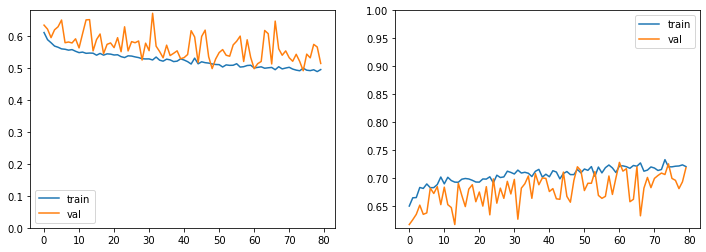

In [29]:
y = np.array([mrk.photo_reqs.mouth_open.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'mouth_open')
list_model_files.append(model_file)

#### *24. Presence of Other Faces or Toys too Close to Face*

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 60s 13ms/step - loss: 0.4704 - accuracy: 0.8048 - precision: 0.9982 - recall: 0.8060 - f1: 0.8870 - specificity: 0.2345 - negative_predictive_value: 0.0395 - matthews_correlation_coefficient: 0.0835 - val_loss: 0.4959 - val_accuracy: 0.7615 - val_precision: 0.9990 - val_recall: 0.7660 - val_f1: 0.8651 - val_specificity: 0.2432 - val_negative_predictive_value: 0.0333 - val_matthews_correlation_coefficient: 0.0754

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.07536, saving model to ../models/autoencoders_requirements/presence_of_other_faces_or_toys_2020_03_24-17_47_54.h5
Epoch 2/100
4610/4610 [==============================] - 42s 9ms/step - loss: 0.2869 - accuracy: 0.8508 - precision: 0.9990 - recall: 0.8512 - f1: 0.9178 - specificity: 0.2414 - negative_predictive_value: 0.0536 - matthews_correlation_coefficient: 0.1017 - val_loss: 0.2468 - val_accuracy: 

4610/4610 [==============================] - 9s 2ms/step - loss: 0.2154 - accuracy: 0.8885 - precision: 0.9993 - recall: 0.8890 - f1: 0.9401 - specificity: 0.2586 - negative_predictive_value: 0.0923 - matthews_correlation_coefficient: 0.1416 - val_loss: 0.4267 - val_accuracy: 0.8066 - val_precision: 0.9990 - val_recall: 0.8105 - val_f1: 0.8931 - val_specificity: 0.2432 - val_negative_predictive_value: 0.0429 - val_matthews_correlation_coefficient: 0.0887

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.11456
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2135 - accuracy: 0.8844 - precision: 0.9995 - recall: 0.8845 - f1: 0.9375 - specificity: 0.2759 - negative_predictive_value: 0.0828 - matthews_correlation_coefficient: 0.1372 - val_loss: 0.3829 - val_accuracy: 0.8448 - val_precision: 0.9990 - val_recall: 0.8479 - val_f1: 0.9155 - val_specificity: 0.2432 - val_negative_predictive_value: 0.0508 - val_matthews_correlation_coefficie


Epoch 00029: val_matthews_correlation_coefficient improved from 0.11742 to 0.11871, saving model to ../models/autoencoders_requirements/presence_of_other_faces_or_toys_2020_03_24-17_47_54.h5
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2018 - accuracy: 0.8844 - precision: 0.9995 - recall: 0.8845 - f1: 0.9374 - specificity: 0.2724 - negative_predictive_value: 0.0790 - matthews_correlation_coefficient: 0.1341 - val_loss: 0.1910 - val_accuracy: 0.9020 - val_precision: 0.9970 - val_recall: 0.9060 - val_f1: 0.9485 - val_specificity: 0.2162 - val_negative_predictive_value: 0.0678 - val_matthews_correlation_coefficient: 0.1096

Epoch 00030: val_matthews_correlation_coefficient did not improve from 0.11871
Epoch 31/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1889 - accuracy: 0.8987 - precision: 0.9998 - recall: 0.8986 - f1: 0.9456 - specificity: 0.2483 - negative_predictive_value: 0.0886 - matthews_correlation_coefficient: 0.1385 -

4610/4610 [==============================] - 9s 2ms/step - loss: 0.1844 - accuracy: 0.8939 - precision: 0.9998 - recall: 0.8938 - f1: 0.9430 - specificity: 0.2690 - negative_predictive_value: 0.0803 - matthews_correlation_coefficient: 0.1366 - val_loss: 0.2782 - val_accuracy: 0.8664 - val_precision: 0.9980 - val_recall: 0.8701 - val_f1: 0.9284 - val_specificity: 0.2297 - val_negative_predictive_value: 0.0523 - val_matthews_correlation_coefficient: 0.0967

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.11921
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1673 - accuracy: 0.8987 - precision: 1.0000 - recall: 0.8984 - f1: 0.9458 - specificity: 0.3034 - negative_predictive_value: 0.0924 - matthews_correlation_coefficient: 0.1567 - val_loss: 0.1855 - val_accuracy: 0.9159 - val_precision: 0.9971 - val_recall: 0.9197 - val_f1: 0.9561 - val_specificity: 0.2162 - val_negative_predictive_value: 0.0791 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.2070 - accuracy: 0.8974 - precision: 0.9995 - recall: 0.8975 - f1: 0.9446 - specificity: 0.2655 - negative_predictive_value: 0.1000 - matthews_correlation_coefficient: 0.1488 - val_loss: 0.3553 - val_accuracy: 0.8465 - val_precision: 0.9990 - val_recall: 0.8495 - val_f1: 0.9166 - val_specificity: 0.2432 - val_negative_predictive_value: 0.0493 - val_matthews_correlation_coefficient: 0.0962

Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.12630
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1735 - accuracy: 0.8976 - precision: 0.9998 - recall: 0.8975 - f1: 0.9451 - specificity: 0.2690 - negative_predictive_value: 0.0831 - matthews_correlation_coefficient: 0.1382 - val_loss: 0.2354 - val_accuracy: 0.8829 - val_precision: 0.9980 - val_recall: 0.8863 - val_f1: 0.9379 - val_specificity: 0.2297 - val_negative_predictive_value: 0.0596 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.1555 - accuracy: 0.9041 - precision: 0.9998 - recall: 0.9041 - f1: 0.9486 - specificity: 0.2759 - negative_predictive_value: 0.1008 - matthews_correlation_coefficient: 0.1541 - val_loss: 0.2908 - val_accuracy: 0.8699 - val_precision: 0.9969 - val_recall: 0.8743 - val_f1: 0.9305 - val_specificity: 0.2162 - val_negative_predictive_value: 0.0492 - val_matthews_correlation_coefficient: 0.0891

Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.12630
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1403 - accuracy: 0.9200 - precision: 1.0000 - recall: 0.9197 - f1: 0.9576 - specificity: 0.2690 - negative_predictive_value: 0.1068 - matthews_correlation_coefficient: 0.1559 - val_loss: 0.2107 - val_accuracy: 0.9254 - val_precision: 0.9962 - val_recall: 0.9299 - val_f1: 0.9613 - val_specificity: 0.1892 - val_negative_predictive_value: 0.0872 - val_matthews_correlation_coefficie

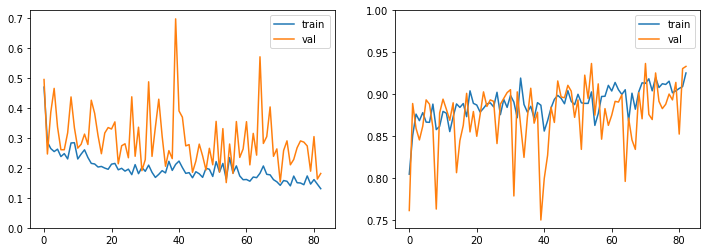

In [30]:
y = np.array([mrk.photo_reqs.presence_of_other_faces_or_toys.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'presence_of_other_faces_or_toys')
list_model_files.append(model_file)

# Models Merge

In [31]:
def add_requirement_branch_to_base_model(base_model_last_layer, req_model):
    req_layers = [layer for layer in req_model.layers if isinstance(layer, Dense)]

    outputs = base_model_last_layer
    for layer in req_layers:
        outputs = req_model.get_layer(layer.name)(outputs)

    return outputs

In [32]:
file_models = np.array([file for file in list_model_files if file is not None])

print(file_models)

['../models/autoencoders_requirements/blurred_2020_03_24-12_31_01.h5'
 '../models/autoencoders_requirements/looking_away_2020_03_24-12_43_57.h5'
 '../models/autoencoders_requirements/unnatural_skin_tone_2020_03_24-12_58_30.h5'
 '../models/autoencoders_requirements/too_dark_light_2020_03_24-13_13_00.h5'
 '../models/autoencoders_requirements/washed_out_2020_03_24-13_19_39.h5'
 '../models/autoencoders_requirements/pixelation_2020_03_24-13_31_08.h5'
 '../models/autoencoders_requirements/hair_across_eyes_2020_03_24-13_37_23.h5'
 '../models/autoencoders_requirements/eyes_closed_2020_03_24-13_52_04.h5'
 '../models/autoencoders_requirements/varied_background_2020_03_24-14_06_56.h5'
 '../models/autoencoders_requirements/roll_pitch_yaw_2020_03_24-14_21_38.h5'
 '../models/autoencoders_requirements/flash_reflection_on_skin_2020_03_24-14_33_42.h5'
 '../models/autoencoders_requirements/red_eyes_2020_03_24-14_48_25.h5'
 '../models/autoencoders_requirements/shadows_behind_head_2020_03_24-15_03_13.h5'


In [33]:
autoencoder = load_model(FILE_BASE_MODEL)

embeddings = GlobalAvgPool2D(name='embeddings')(autoencoder.get_layer(name='encoded').output)

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


In [34]:
custom_objects = {
    'recall': recall,
    'precision': precision,
    'f1': f1,
    'specificity': specificity,
    'negative_predictive_value': npv,
    'matthews_correlation_coefficient': mcc
}

list_models = [load_model(file, custom_objects=custom_objects) for file in file_models]
list_outputs = [add_requirement_branch_to_base_model(embeddings, model) for model in list_models]

In [35]:
merged_model = Model(inputs=autoencoder.inputs, outputs=list_outputs)
merged_model.summary()

merged_model.save(FILE_MERGED_MODEL)

Model: "model_24"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 224, 224, 16) 448         input[0][0]                      
__________________________________________________________________________________________________
bn_1 (BatchNormalization)       (None, 224, 224, 16) 64          conv_1[0][0]                     
__________________________________________________________________________________________________
relu_1 (Activation)             (None, 224, 224, 16) 0           bn_1[0][0]                       
___________________________________________________________________________________________

In [ ]:
import cv2
from glob import glob

# list_files = glob('../data/pybossa/images/*')
list_files = ['../data/pybossa/images\AR_FDB_m-013-17.png']
random_file = np.random.choice(list_files)
print(random_file)

im = load.images_from_list_files([random_file], output_size=IMAGE_SIZE, interpolation=cv2.INTER_AREA)
im /= 255

y_pred = merged_model.predict(im)
list_predictions = [model.predict(im) for model in list_models]
assert(np.all([np.allclose(pred1, pred2) for pred1, pred2 in zip(y_pred, list_predictions)]))

y_pred